In [1]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
import regex as re
import pickle as pkl
import seaborn as sns

In [3]:
import ecephys_analyses.psth
from ecephys_analyses.data import paths

In [102]:
from ecephys.plot import plot_psth_heatmap

In [4]:
import ecephys_analyses.psth

In [5]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [154]:
def get_average_psth_path(
    subject, condition, sorting_condition,
    region=None, state=None, good_only=None, normalize=None
):
    filename = (
        f"average_psth_{sorting_condition}"
        f"_good={good_only}_region={region}_state={state}_normalize={normalize}"
        f".pkl"
    )
    return paths.get_datapath(
        subject, condition, filename
    )

def get_average_psth_data(
    subject, condition, sorting_condition,
    region=None, state=None, good_only=None, normalize=None,
):
    average_psth_path = get_average_psth_path(
        subject, condition, sorting_condition,
        region=region,
        state=state,
        good_only=good_only,
        normalize=normalize,
    )
    if average_psth_path.exists():
        with open(average_psth_path, 'rb') as f:
            return pkl.load(f)
    
    print(f"Compute average psth, save at {average_psth_path}")
    average_psth, info, event_df = ecephys_analyses.psth.get_average_psth_data(
        subject, condition, sorting_condition,
        region=region,
        state=state,
        good_only=good_only,
        normalize=normalize,
    )
    dat = {
        'psth_dict': average_psth,
        'cluster_info': info,
        'event_df': event_df,
    }
    with open(average_psth_path, 'wb') as f:
        pkl.dump(dat, f)
    return dat

def dump_all_average_psth_data(filepath, window, binsize, depths, n_clusters, psth_array, conditions):
    print(f"Dump data at {filepath}")
    times = np.arange(window[0], window[1], binsize)
    assert len(times) == psth_array.shape[1]
    dump = {
        'conditions': conditions,
        'condition_depths': depths,
        'condition_n_clusters': n_clusters,
        'average_psth_array': psth_array,
        'window': window,
        'binsize': binsize,
        'times': times,
    }
    # As pickle
    import pickle as pkl
    with open(filepath.with_suffix('.pkl'), 'wb') as f:
        pkl.dump(dump, f)
    # As mat
    import scipy.io
    scipy.io.savemat(filepath.with_suffix('.mat'), dump)

In [155]:
def make_average_psth_figures(
    subject, condition_group, sorting_condition, imec,
    good_only=False, normalize='baseline_zscore',
    region='cortex', state=None, save=False, show=True,
    output_dir=None, clim=None, dump_data=False,
):
    if output_dir is None:
        # Save in condition dir
        output_dir = paths.get_datapath(subject, condition_group, 'plots')
        output_dir.mkdir(exist_ok=True, parents=True)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    print(
        f"Generate figures for {subject} {condition_group}, imec{imec}, {sorting_condition}, {state}, "
        f"{region}, good={good_only}, output={output_dir}",
    )
    
    # Select conditions of interest
    conditions = paths.get_conditions(subject, condition_group)
    conditions = [
        cond for cond in conditions if f"imec{imec}" in cond
    ]
    if state is not None:
        conditions = [
            cond for cond in conditions if f'_{state}_' in cond
        ]
    print(f"N={len(conditions)} selected conditions: {conditions}")
    
    # Depth for each condition
    depths = []
    for cond in conditions:
        x = re.search(r"_depth.*_", cond)
        depth = float(x.group().split('_depth')[1].split('_')[0])
        depths.append(depth)
    
    # average psth for each condition
    all_psth_dat = [
        get_average_psth_data(
            subject, cond, sorting_condition,
            region=region, 
            state=state,
            good_only=good_only,
            normalize=normalize,
        ) for cond in conditions
    ]
    # Checks all same params
    assert len(set([dat['psth_dict']['binsize'] for dat in all_psth_dat])) == 1
    assert len(set([dat['psth_dict']['window'][0] for dat in all_psth_dat])) == 1
    assert len(set([dat['psth_dict']['window'][1] for dat in all_psth_dat])) == 1
    window = all_psth_dat[0]['psth_dict']['window']
    binsize = all_psth_dat[0]['psth_dict']['binsize']
    # Check single condition for each data
    assert all([len(dat['psth_dict']['data'].keys()) == 1 for dat in all_psth_dat])
    
    n_clusters = [
        dat['psth_dict']['n_clusters'] for dat in all_psth_dat
    ]
    average_psths = [
        dat['psth_dict']['data'][0] for dat in all_psth_dat
    ]

    # Sort data by depth
    def sort_lists_by(lists, key_list=0, desc=False):
        return zip(
            *sorted(zip(*lists), reverse=desc, key=lambda x: x[key_list])
        )
    depths, n_clusters, average_psths, conditions = sort_lists_by(
        [depths, n_clusters, average_psths, conditions], key_list=0, desc=False
    )
    
    # Plot:
    psth_array = np.vstack(average_psths)
    ylabels = [
        f'd={depth} | N={n_clus}'
        for depth, n_clus in zip(depths, n_clusters)
    ]
    fig, ax = plot_psth_heatmap(
        psth_array, ylabels, window, binsize, clim=clim,
        cbar_label='Average rate (Z-scored)'
    )
    
    # Title
    title=f"Average PSTH: {subject}, {condition_group}, imec{imec}\n"
    if state is not None:
        title+=f"State={state}; "
    if region is not None:
        title+=f'Region={region}; '
    if good_only:
        title+='"good" clusters'
    else:
        title+=f'all clusters'
    plt.title(title)
    plt.ylabel('Stimulation depth | N clusters')
    plt.xlabel('Time to pulse (msec)')
    
    
    if show:
        plt.show()
    
    if save:
        filename = f"average_psth_imec{imec}_{state}_region={region}_goodonly={good_only}_norm={normalize}_clim={clim}"
        savepath = Path(output_dir)/(filename.replace(' ','') + '.png')
        print(f'save at {savepath}')
        fig.savefig(savepath, bbox_inches='tight')

    if dump_data:
        filename = f'average_psths_imec{imec}_region={region}_state={state}_good={good_only}'
        filepath = paths.get_datapath(subject, condition_group, filename)
        window = all_psth_dat[0]['psth_dict']['window']
        binsize = all_psth_dat[0]['psth_dict']['binsize']
        dump_all_average_psth_data(
            filepath, window, binsize, depths, n_clusters, psth_array, conditions
        )


Generate figures for Eugene eStim, imec0, ks2_5_catgt_df, NREM, cortex, good=False, output=.
N=11 selected conditions: ['10-9-2020_NREM_depth1.5_imec0', '10-19-2020_NREM_depth1.5_imec0', '10-2-2020_NREM_depth1.4_imec0', '10-9-2020_NREM_depth1.2_imec0', '10-2-2020_NREM_depth1.1_imec0', '10-9-2020_NREM_depth0.9_imec0', '10-2-2020_NREM_depth0.8_imec0', '10-9-2020_NREM_depth0.6_imec0', '10-2-2020_NREM_depth0.5_imec0', '10-9-2020_NREM_depth0.3_imec0', '10-2-2020_NREM_depth0.2_imec0']


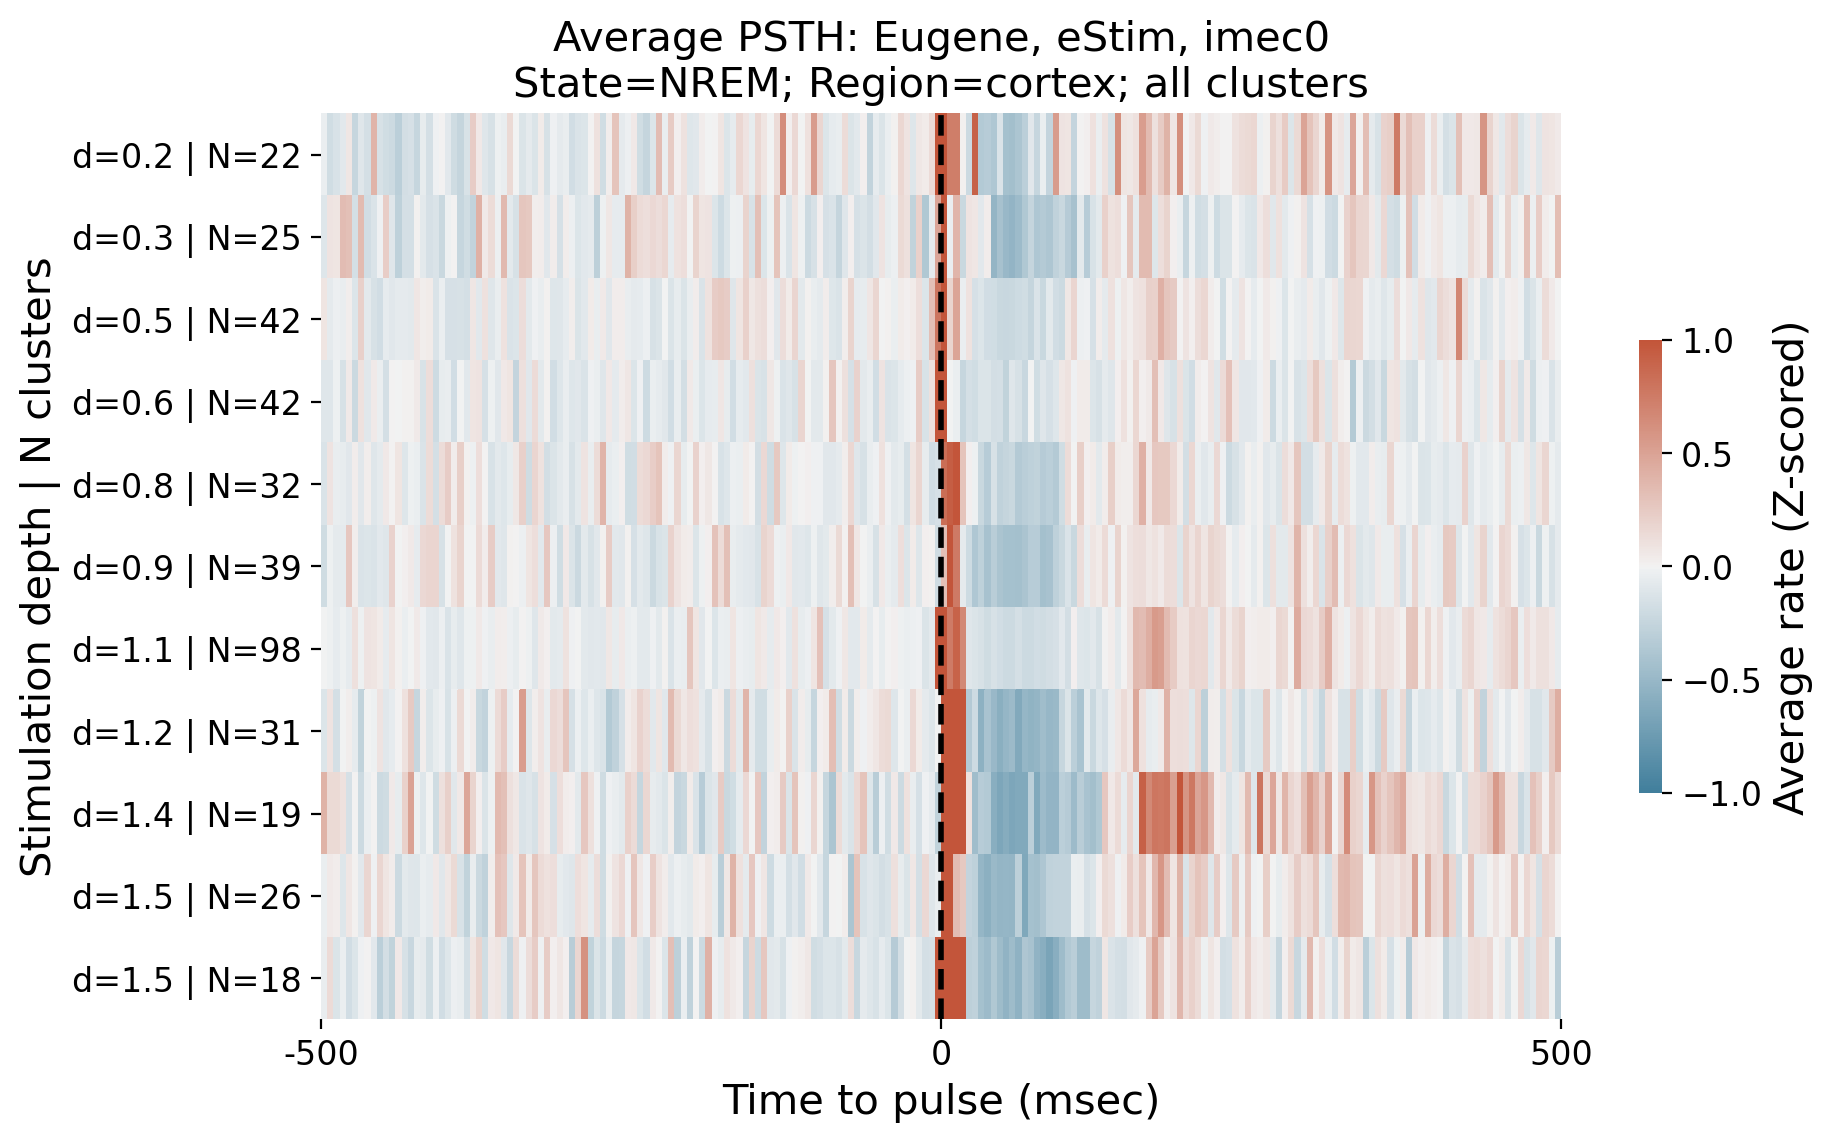

save at average_psth_imec0_NREM_region=cortex_goodonly=False_norm=baseline_zscore_clim=[-1,1].png
Dump data at /Volumes/neuropixel/Data/tom/catgt/CNPIX6-Eugene/eStim/average_psths_imec0_region=cortex_state=NREM_good=False


In [156]:
make_average_psth_figures(
    'Eugene', 'eStim', 'ks2_5_catgt_df', 0,
    good_only=False, normalize='baseline_zscore',
    region='cortex', state='NREM', save=True, show=True,
    clim=[-1, 1],
    output_dir='.',
    dump_data=True,
)

# All

In [157]:
sorting_condition = 'ks2_5_catgt_df'

OUTPUT_DIR = None  # Save in subject/condition_group/plots

In [158]:
clim_values = [
    [-1, 1],
]

good_only_values = [
    True,
    False,
]

states = [
    'NREM',
    'REM',
    'Wake',
    'Sevo'
]

regions = [
    'cortex',
#     'all',
]

imecs = [
    0, 1
]

subject = 'Eugene'
condition_group = 'eStim'

In [121]:
n_jobs = 1

Generate figures for Eugene eStim, imec0, ks2_5_catgt_df, NREM, cortex, good=True, output=/Volumes/neuropixel/Data/tom/catgt/CNPIX6-Eugene/eStim/plots
N=11 selected conditions: ['10-9-2020_NREM_depth1.5_imec0', '10-19-2020_NREM_depth1.5_imec0', '10-2-2020_NREM_depth1.4_imec0', '10-9-2020_NREM_depth1.2_imec0', '10-2-2020_NREM_depth1.1_imec0', '10-9-2020_NREM_depth0.9_imec0', '10-2-2020_NREM_depth0.8_imec0', '10-9-2020_NREM_depth0.6_imec0', '10-2-2020_NREM_depth0.5_imec0', '10-9-2020_NREM_depth0.3_imec0', '10-2-2020_NREM_depth0.2_imec0']
save at /Volumes/neuropixel/Data/tom/catgt/CNPIX6-Eugene/eStim/plots/average_psth_imec0_NREM_region=cortex_goodonly=True_norm=baseline_zscore_clim=[-1,1].png
Dump data at /Volumes/neuropixel/Data/tom/catgt/CNPIX6-Eugene/eStim/average_psths_imec0_region=cortex_state=NREM_good=True
Generate figures for Eugene eStim, imec0, ks2_5_catgt_df, REM, cortex, good=True, output=/Volumes/neuropixel/Data/tom/catgt/CNPIX6-Eugene/eStim/plots
N=1 selected conditions: ['

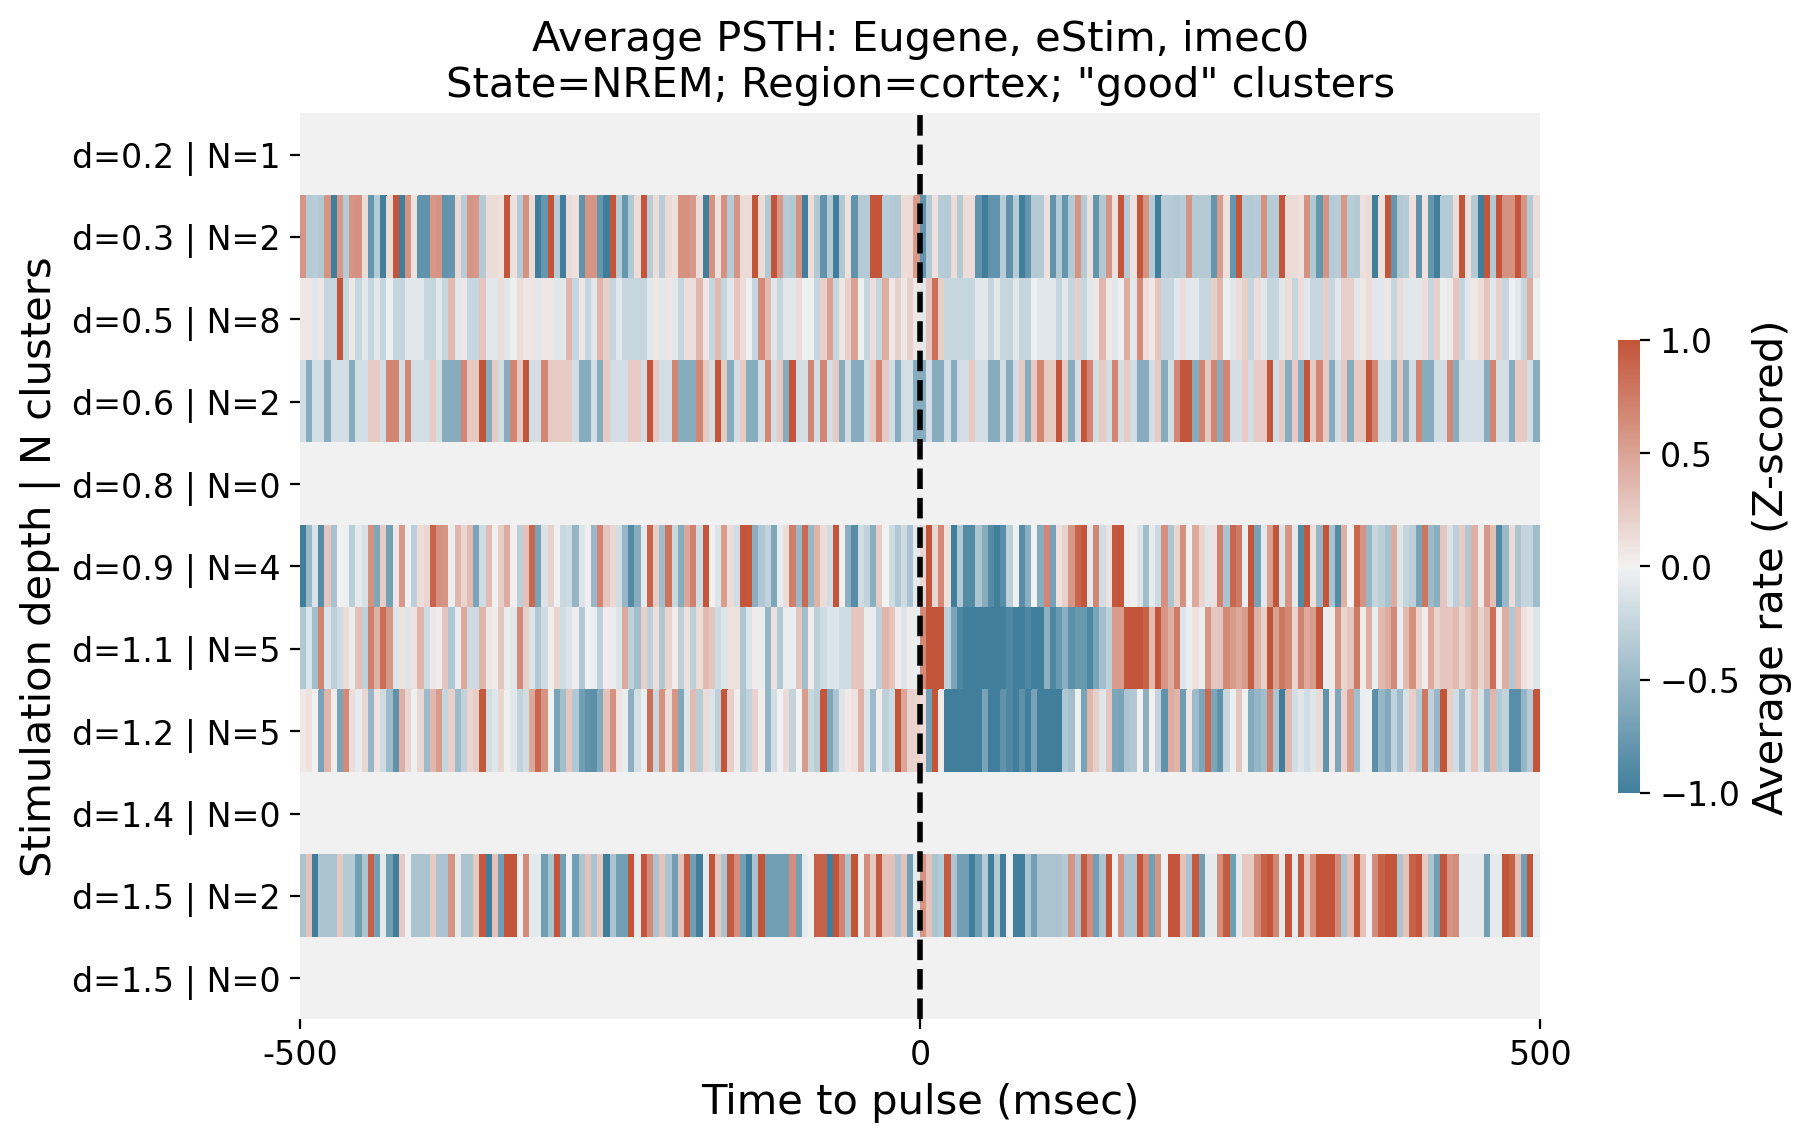

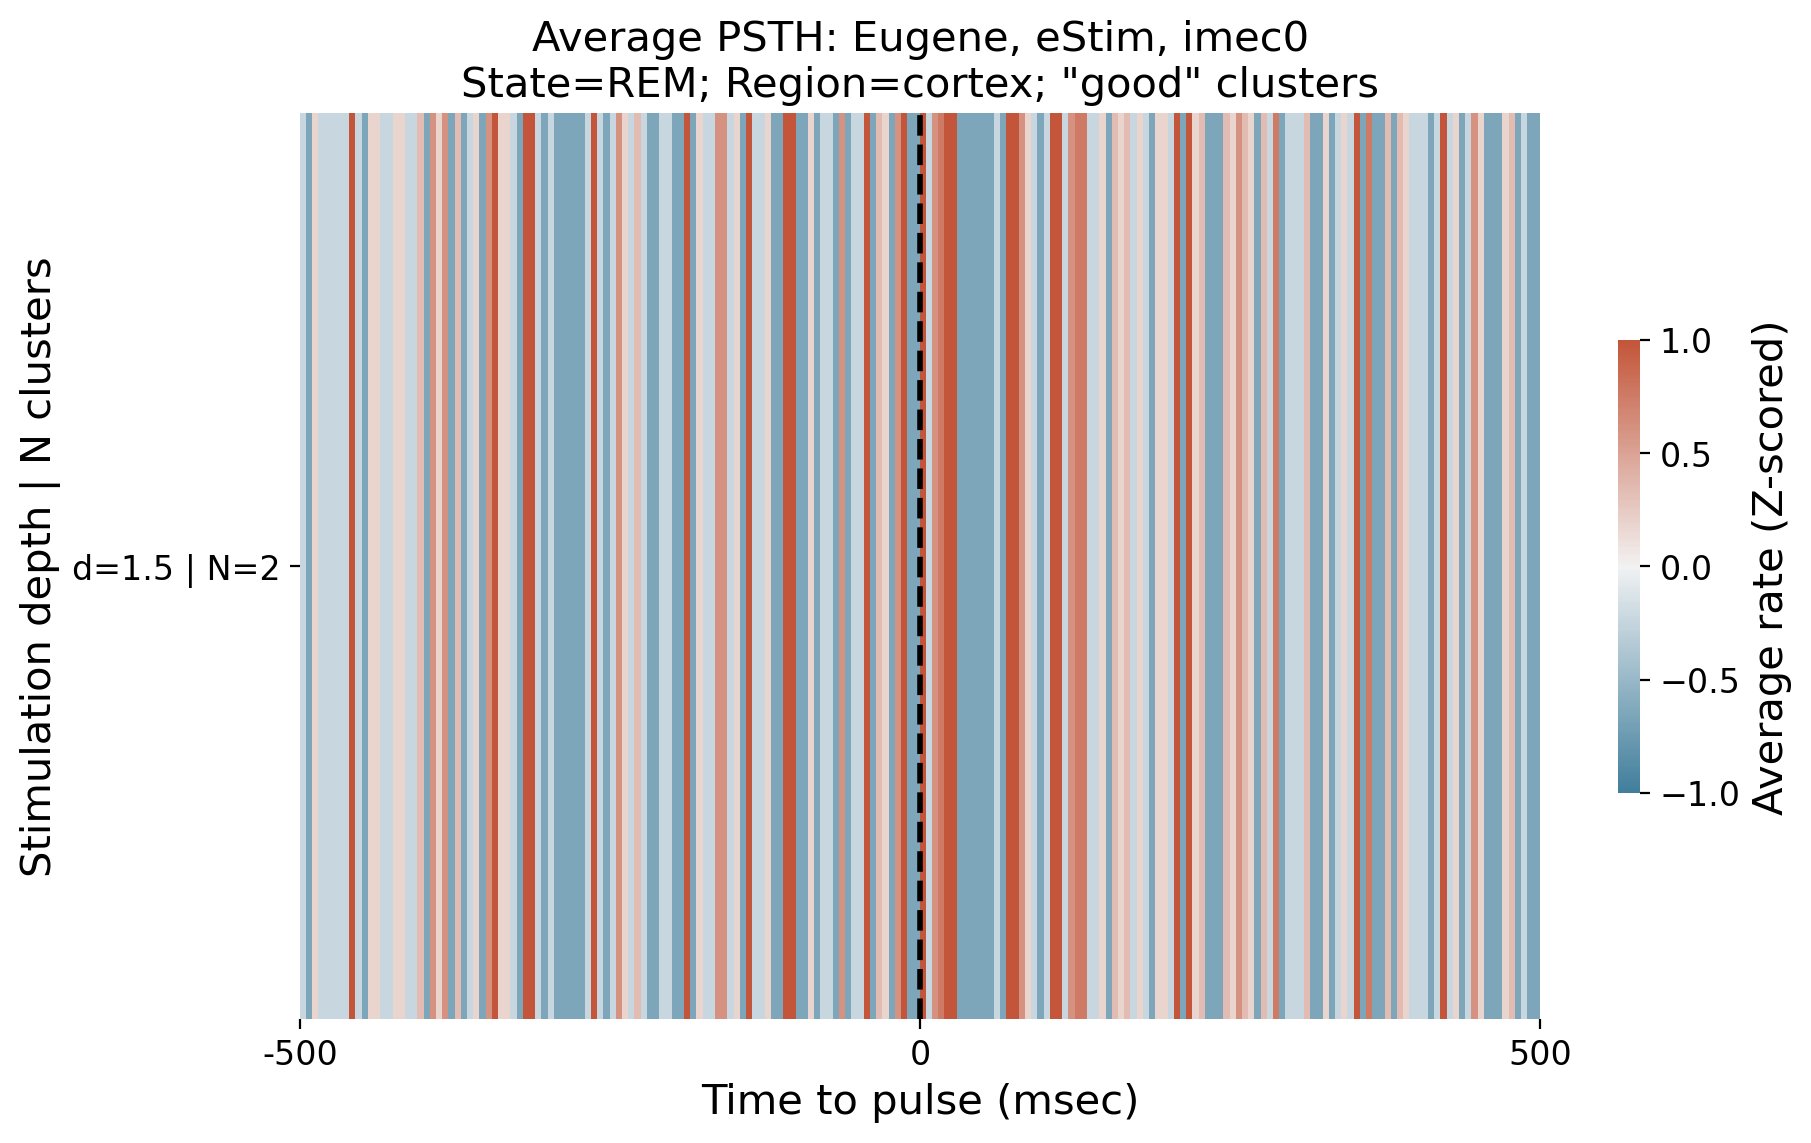

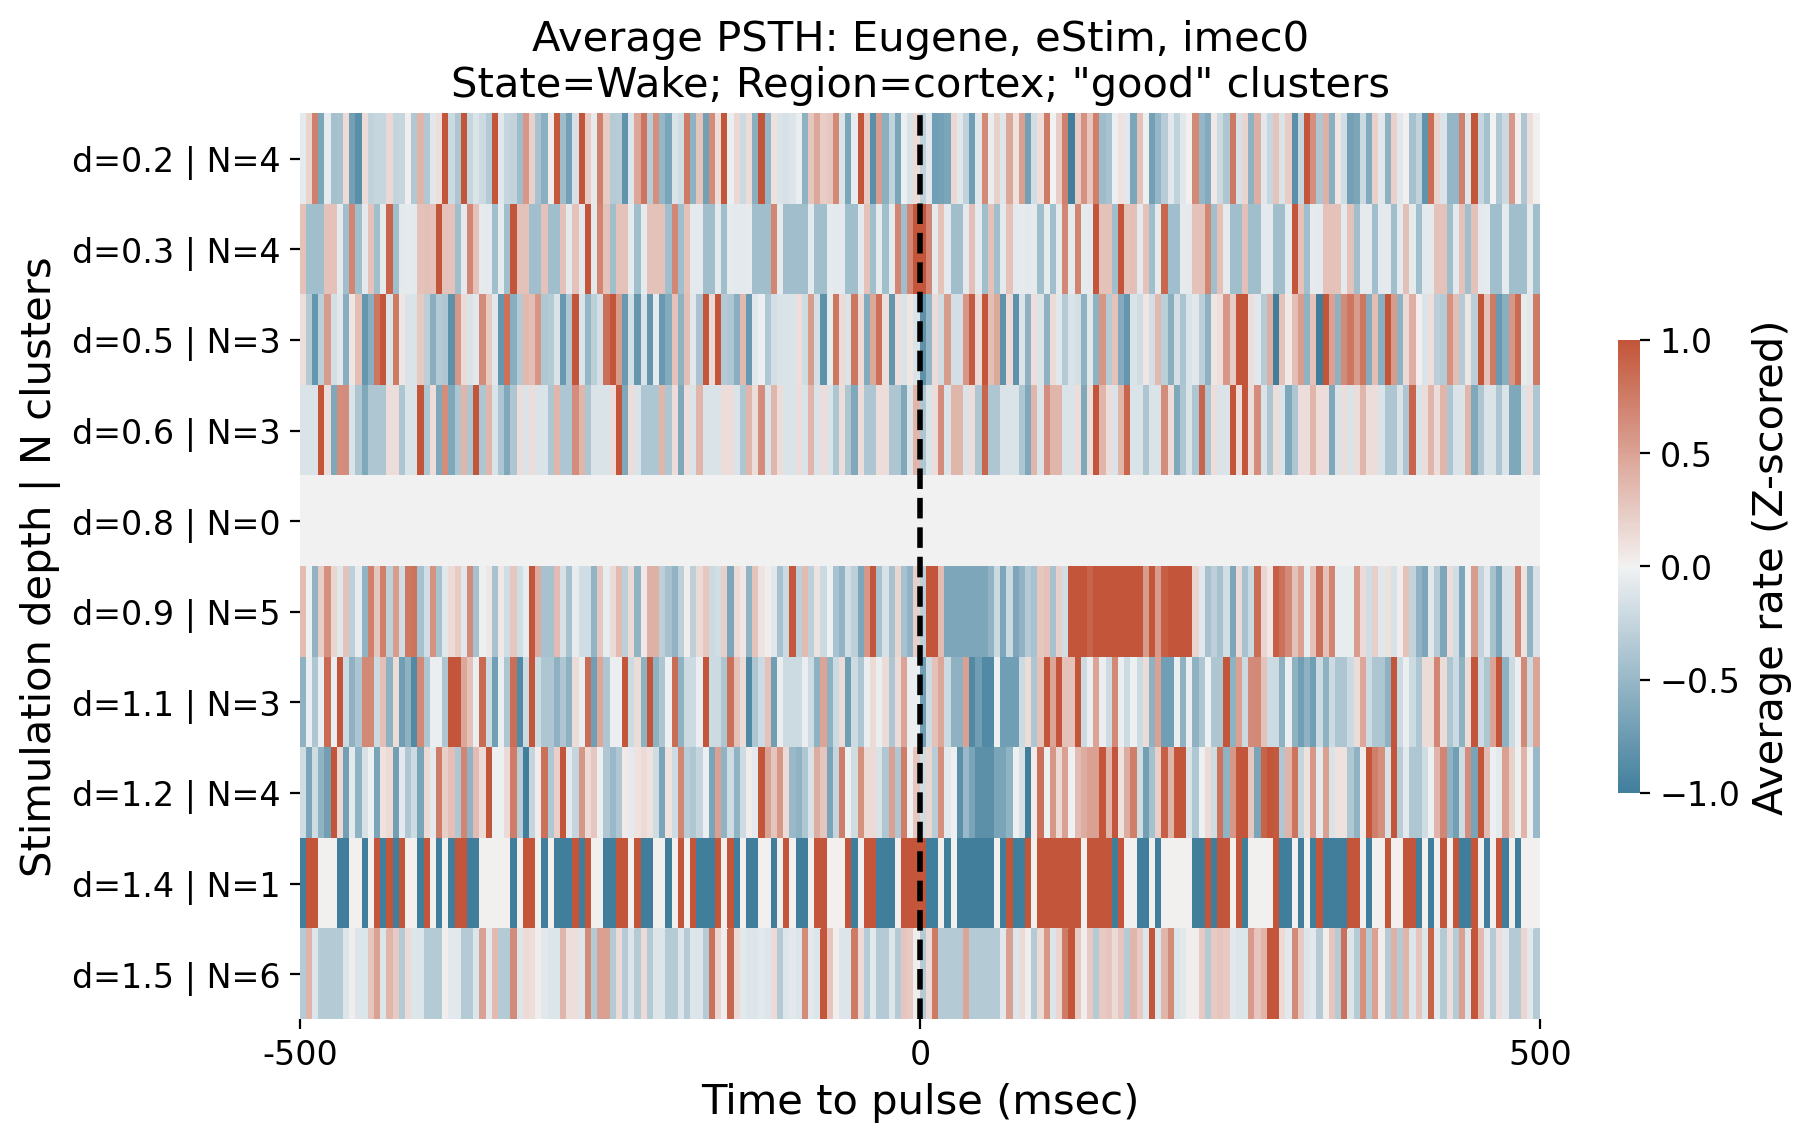

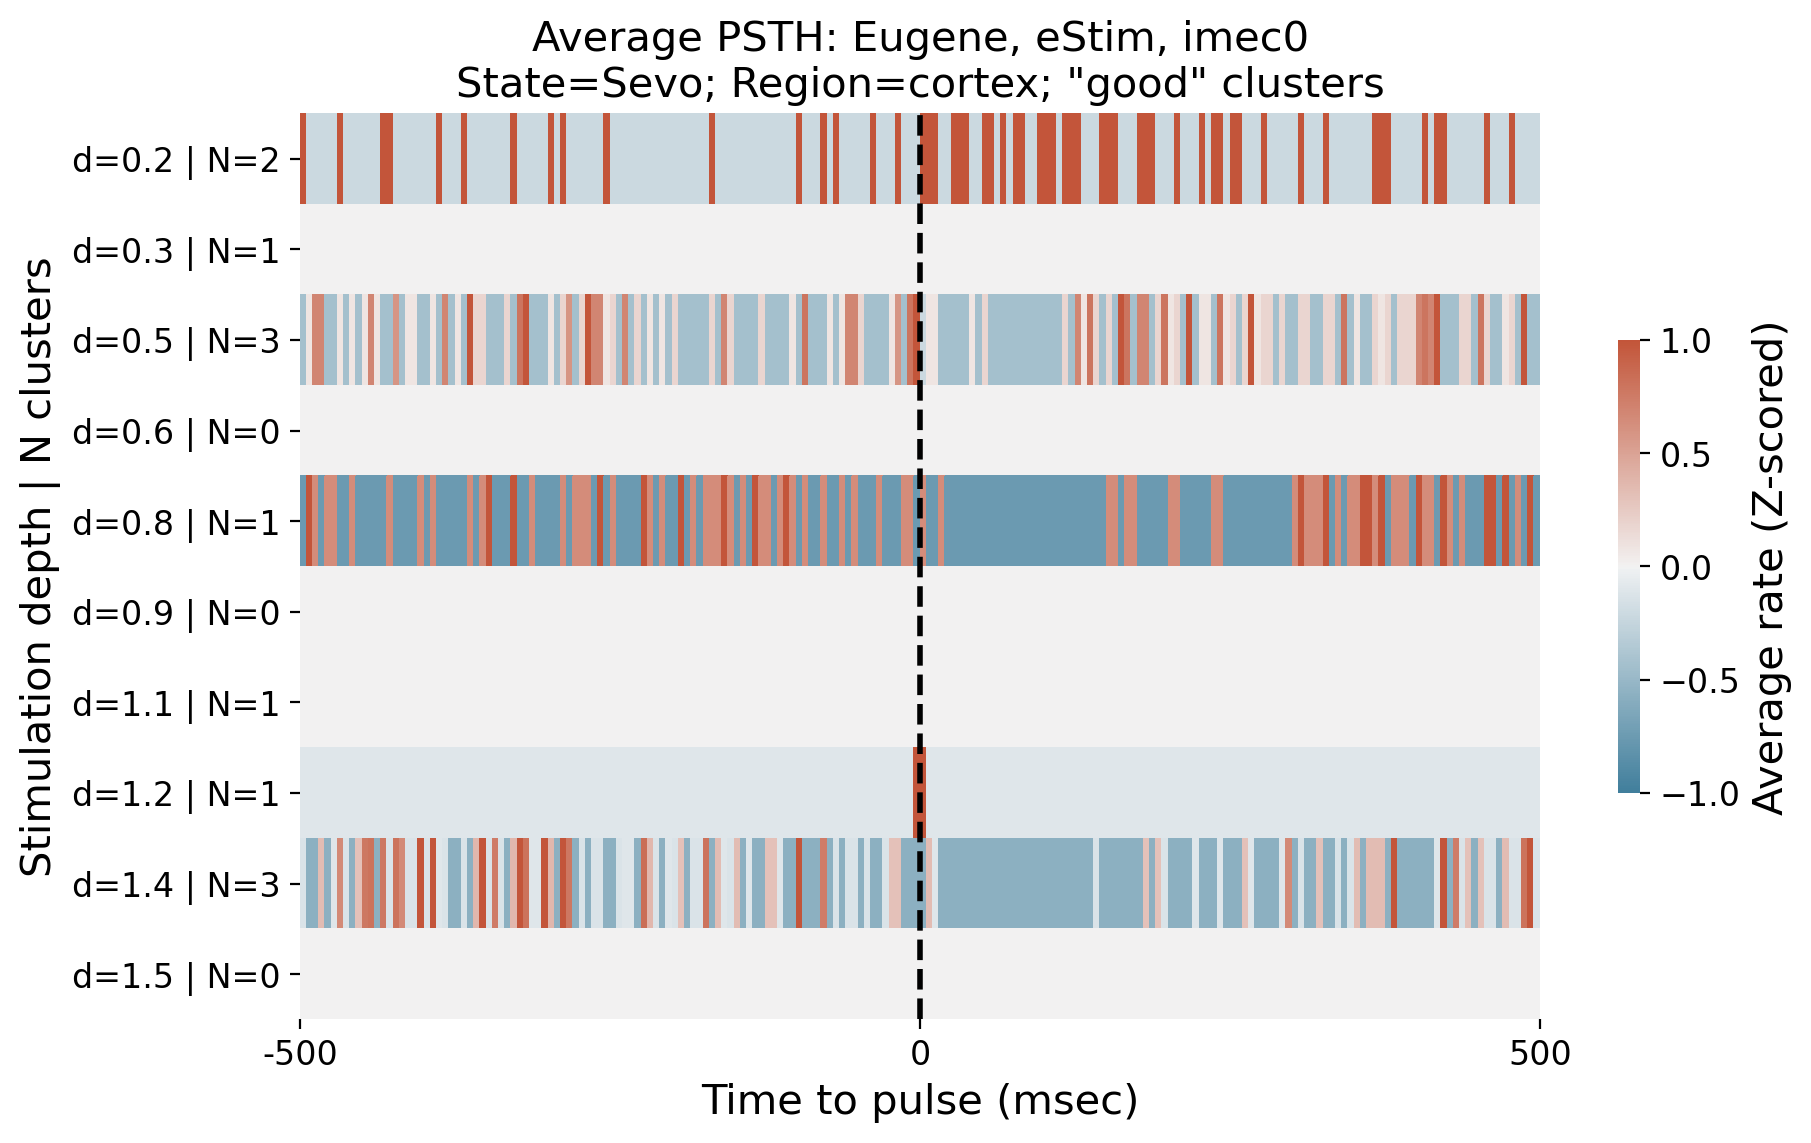

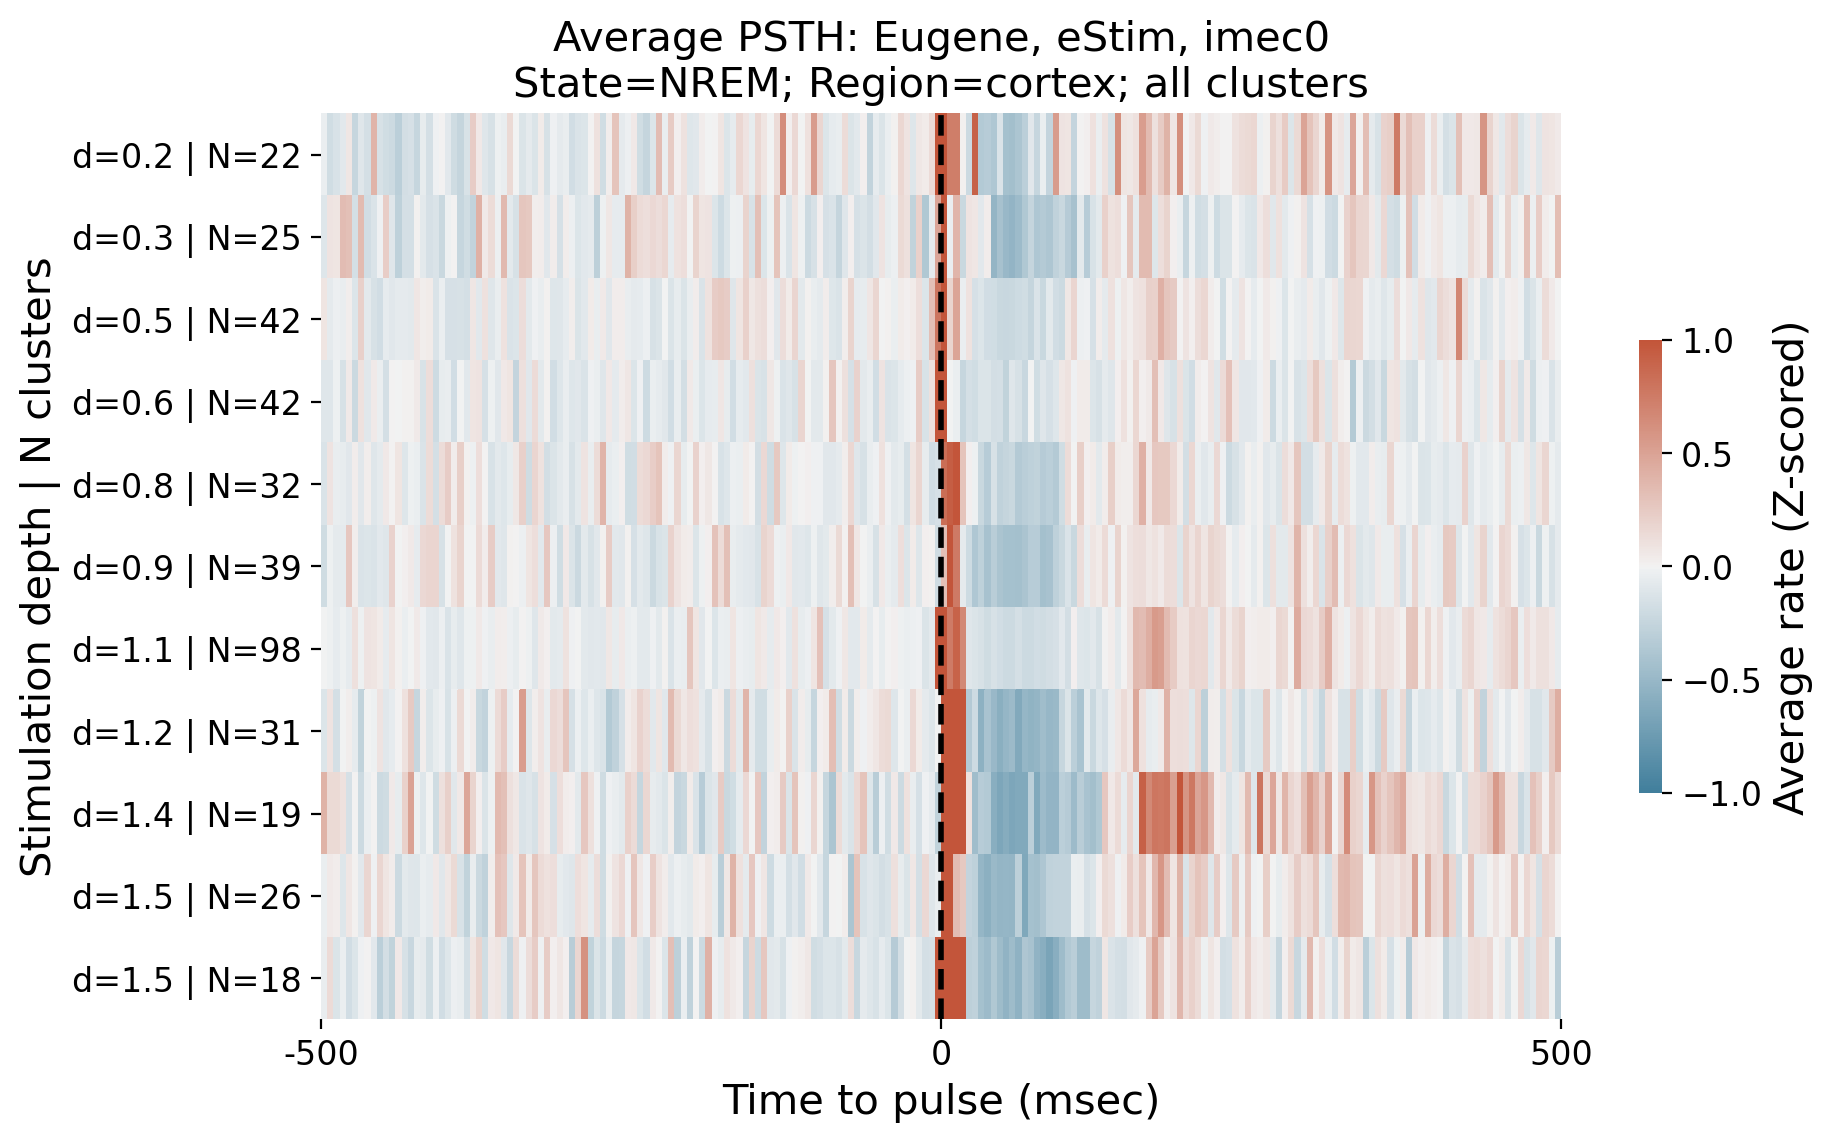

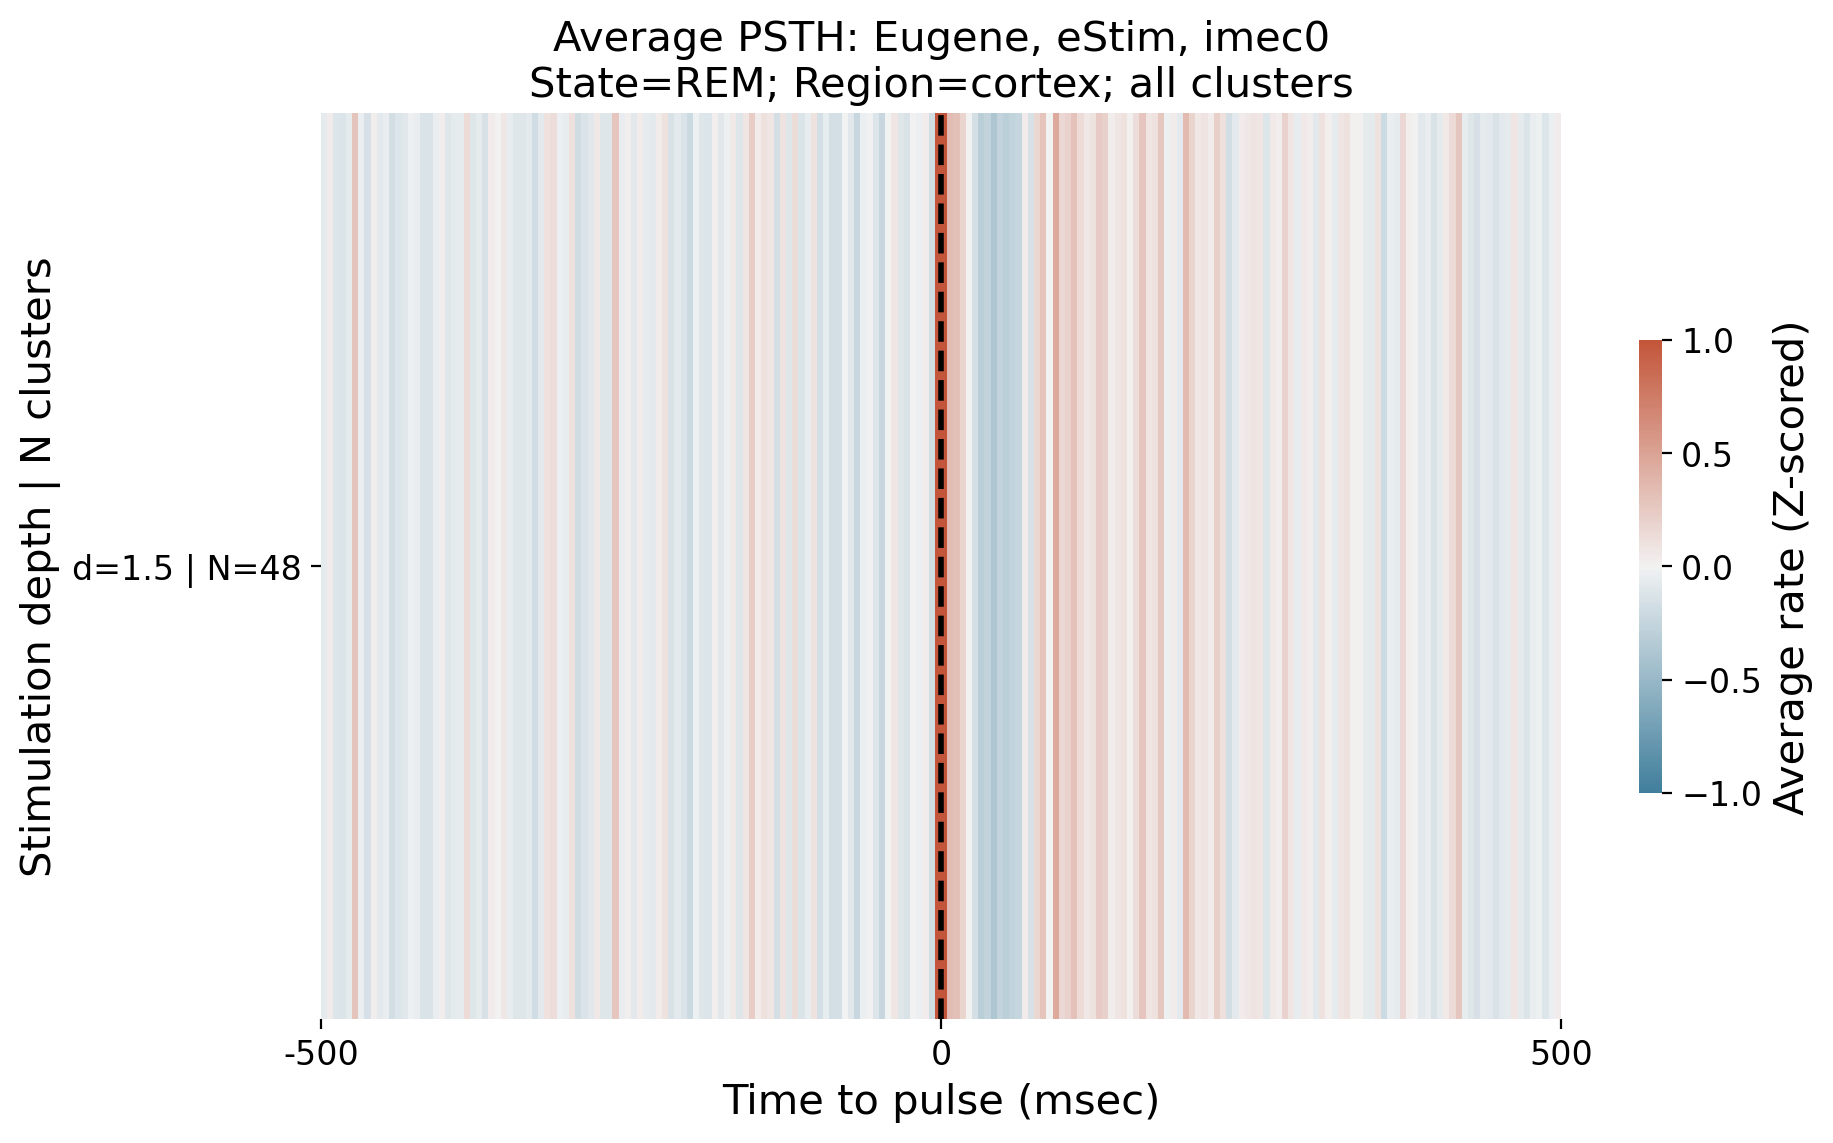

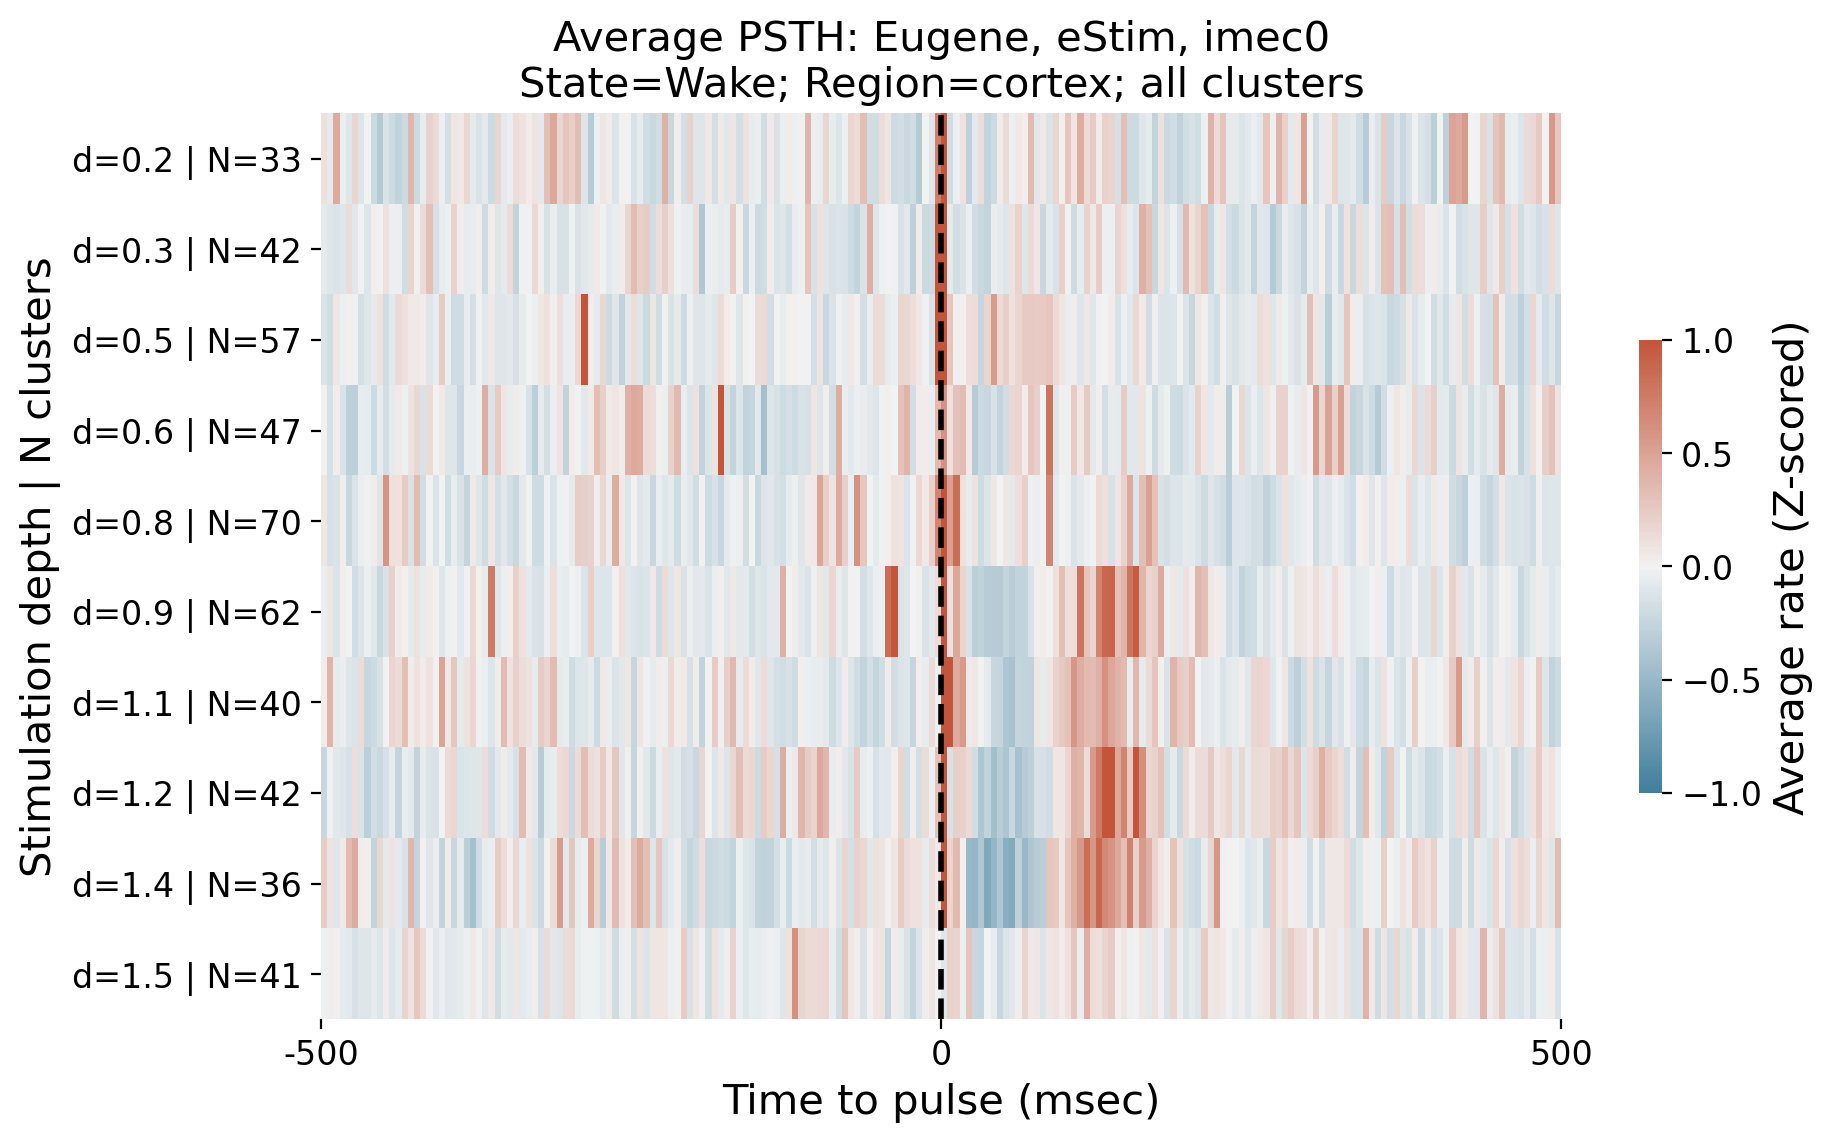

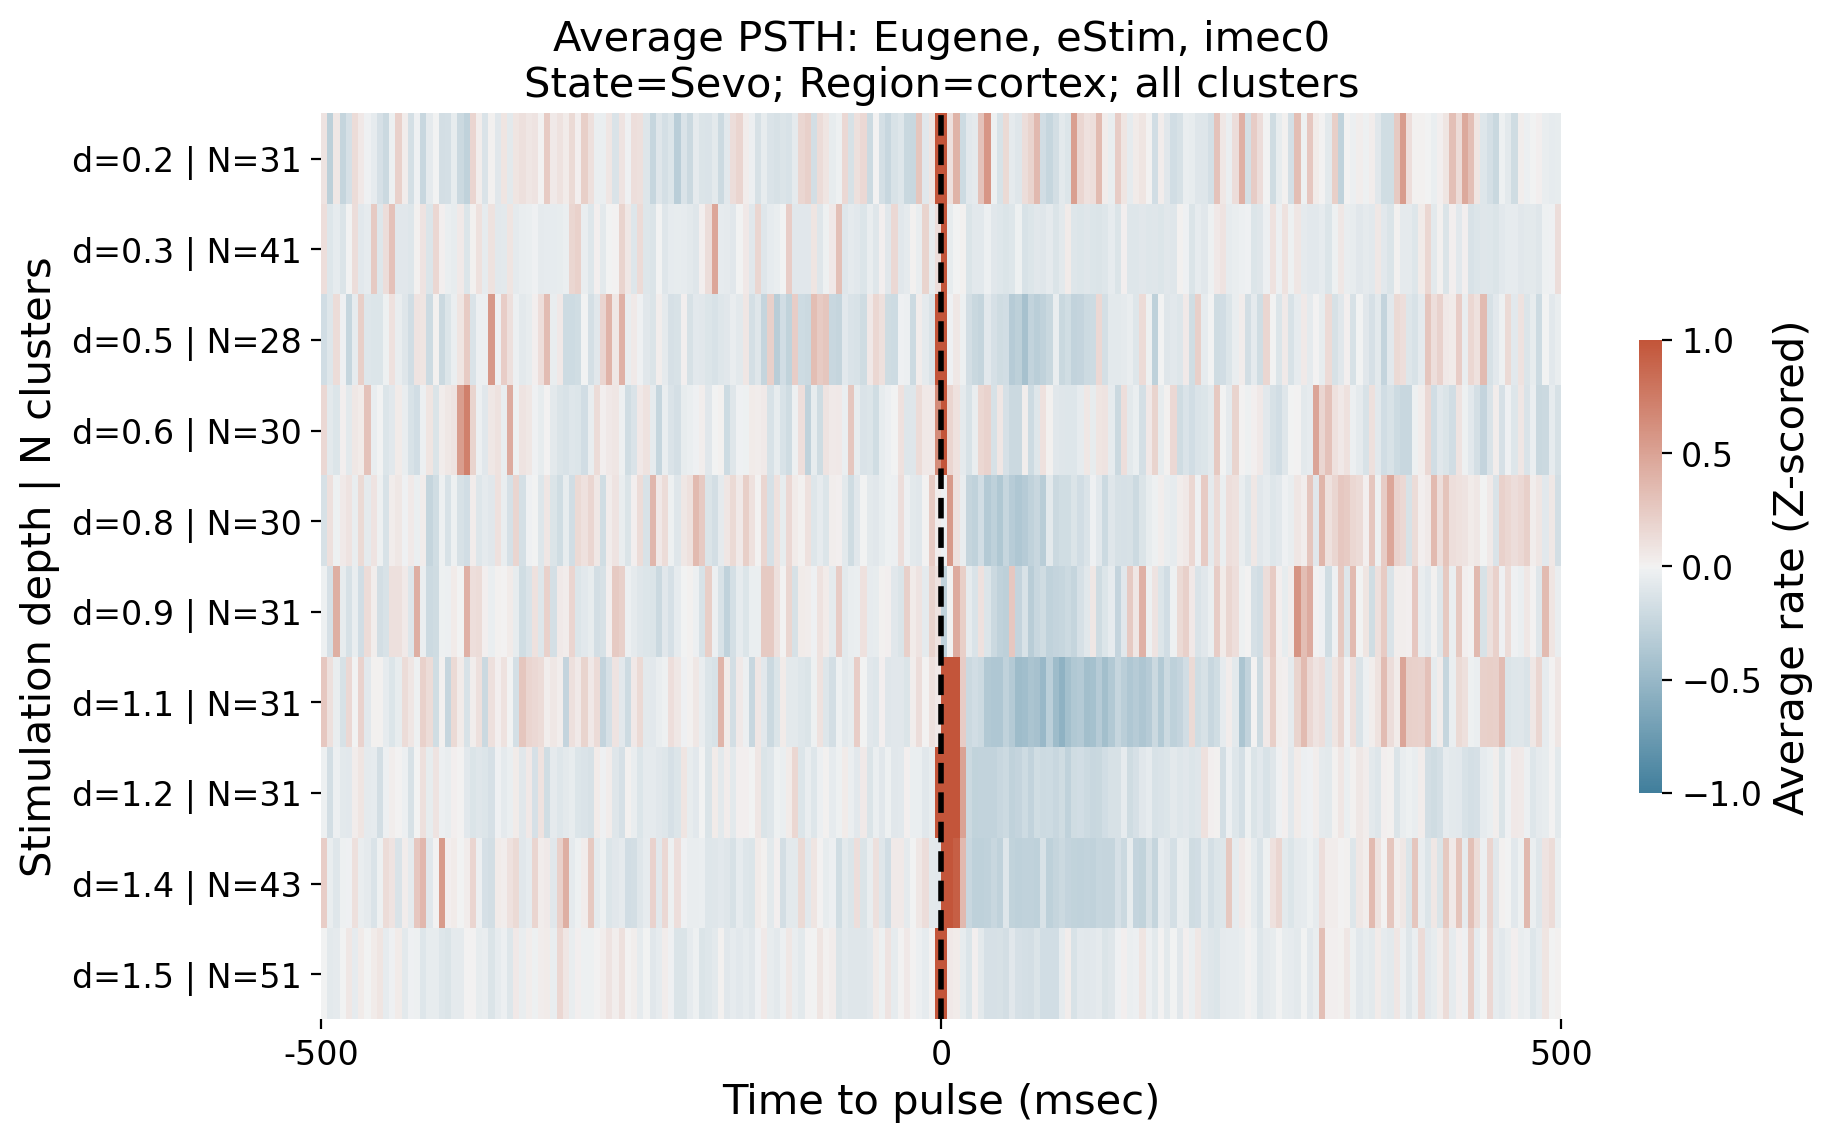

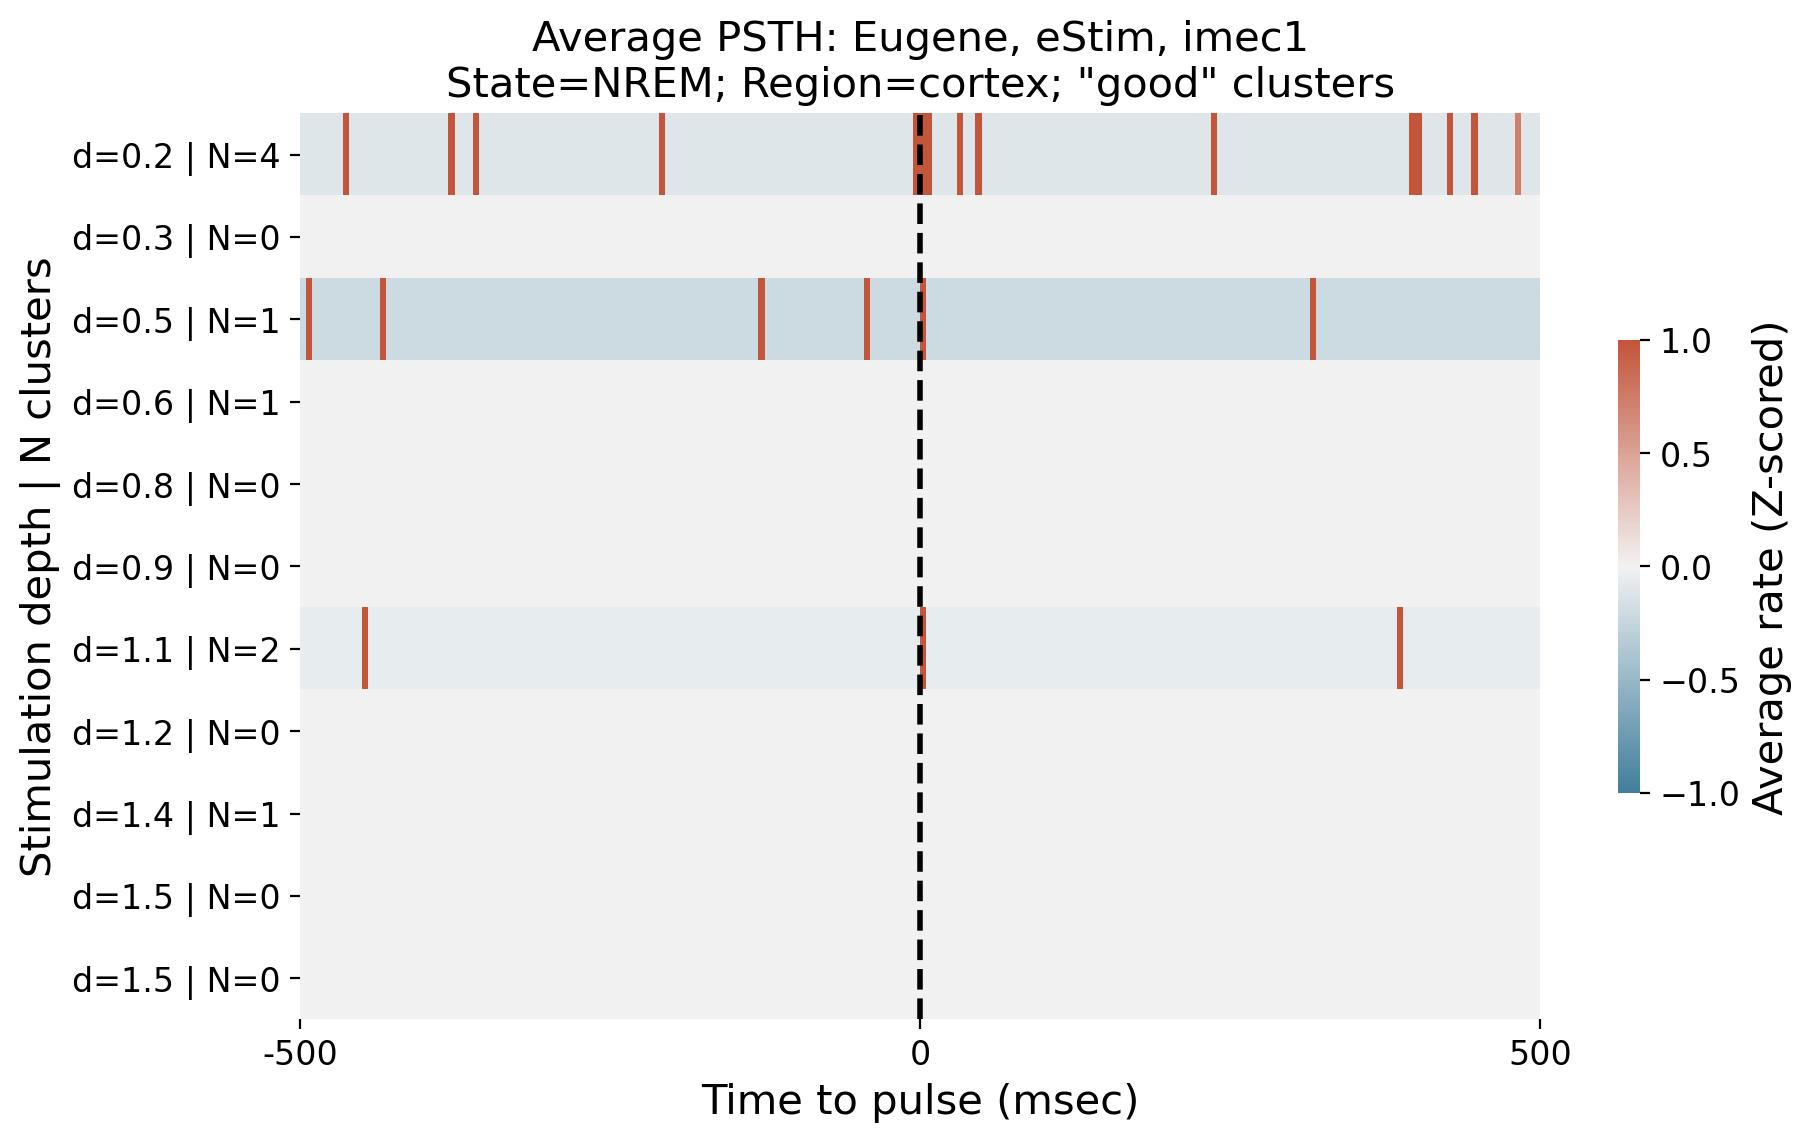

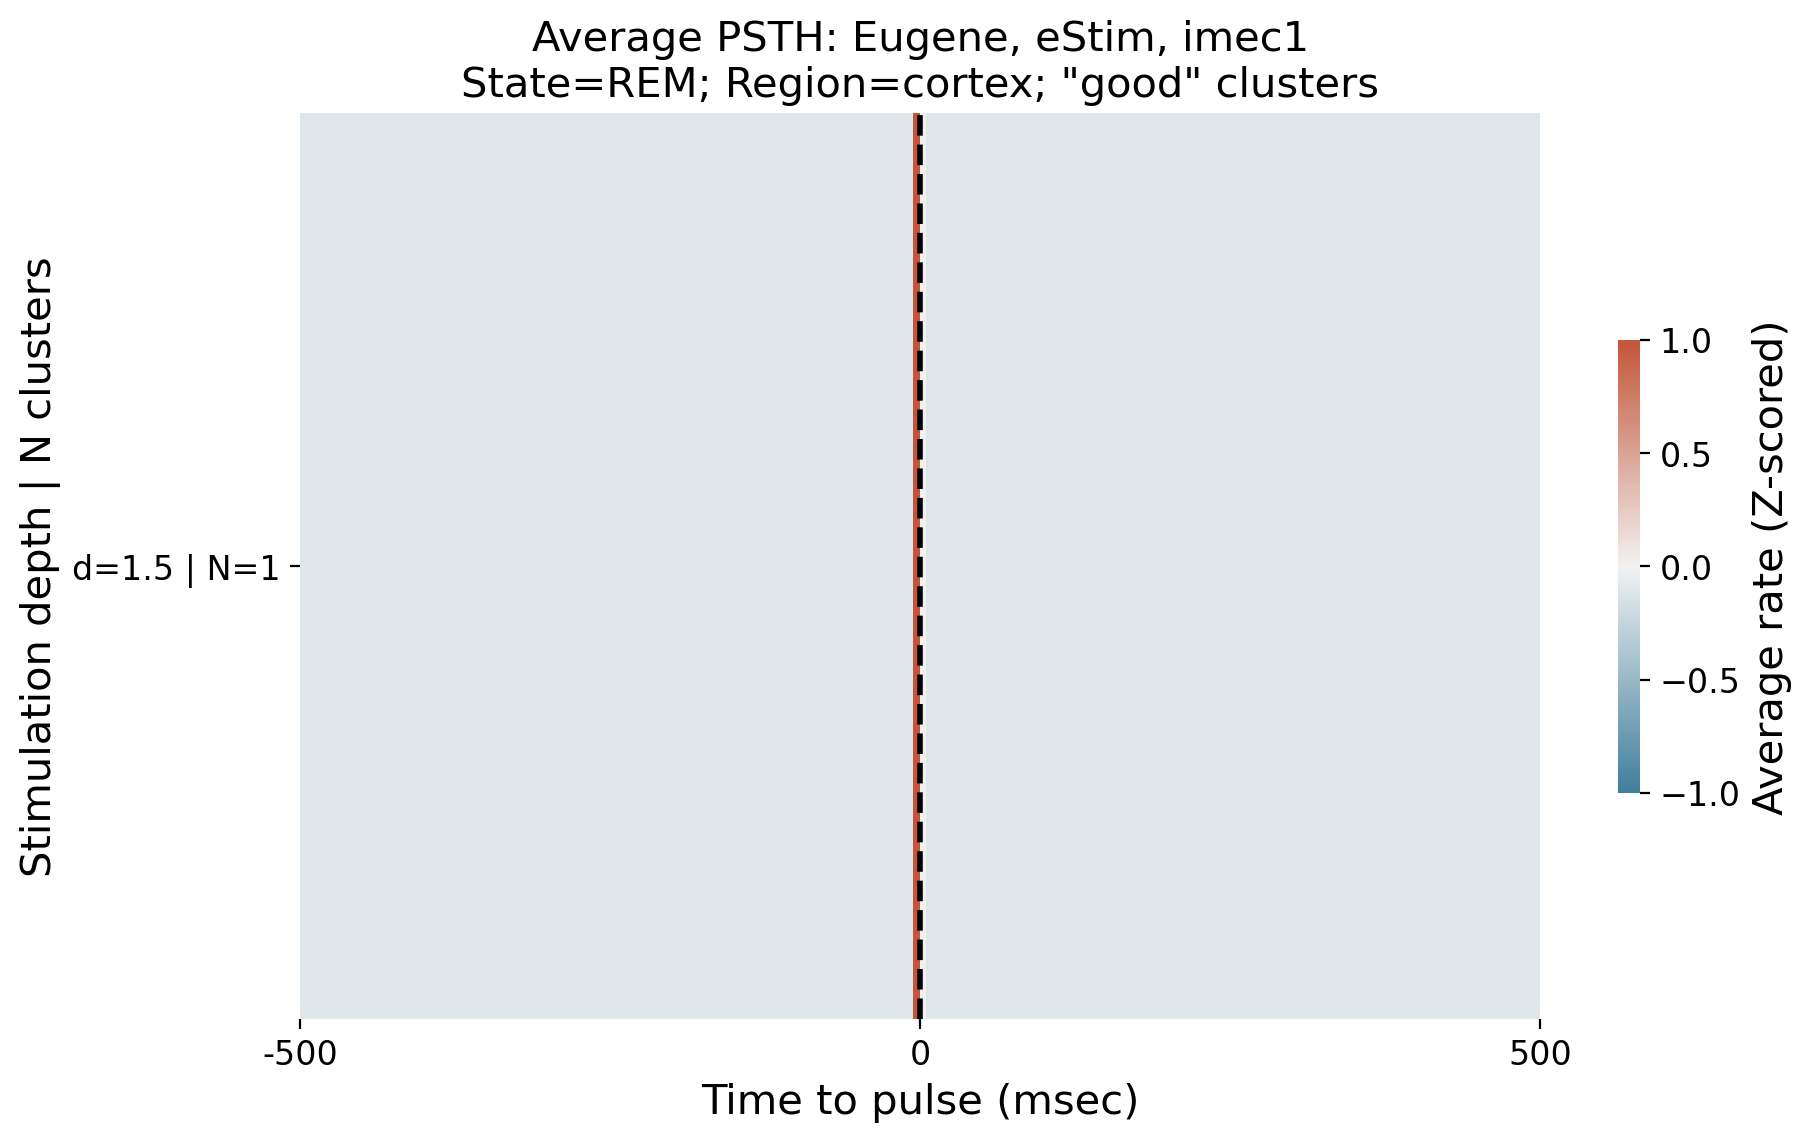

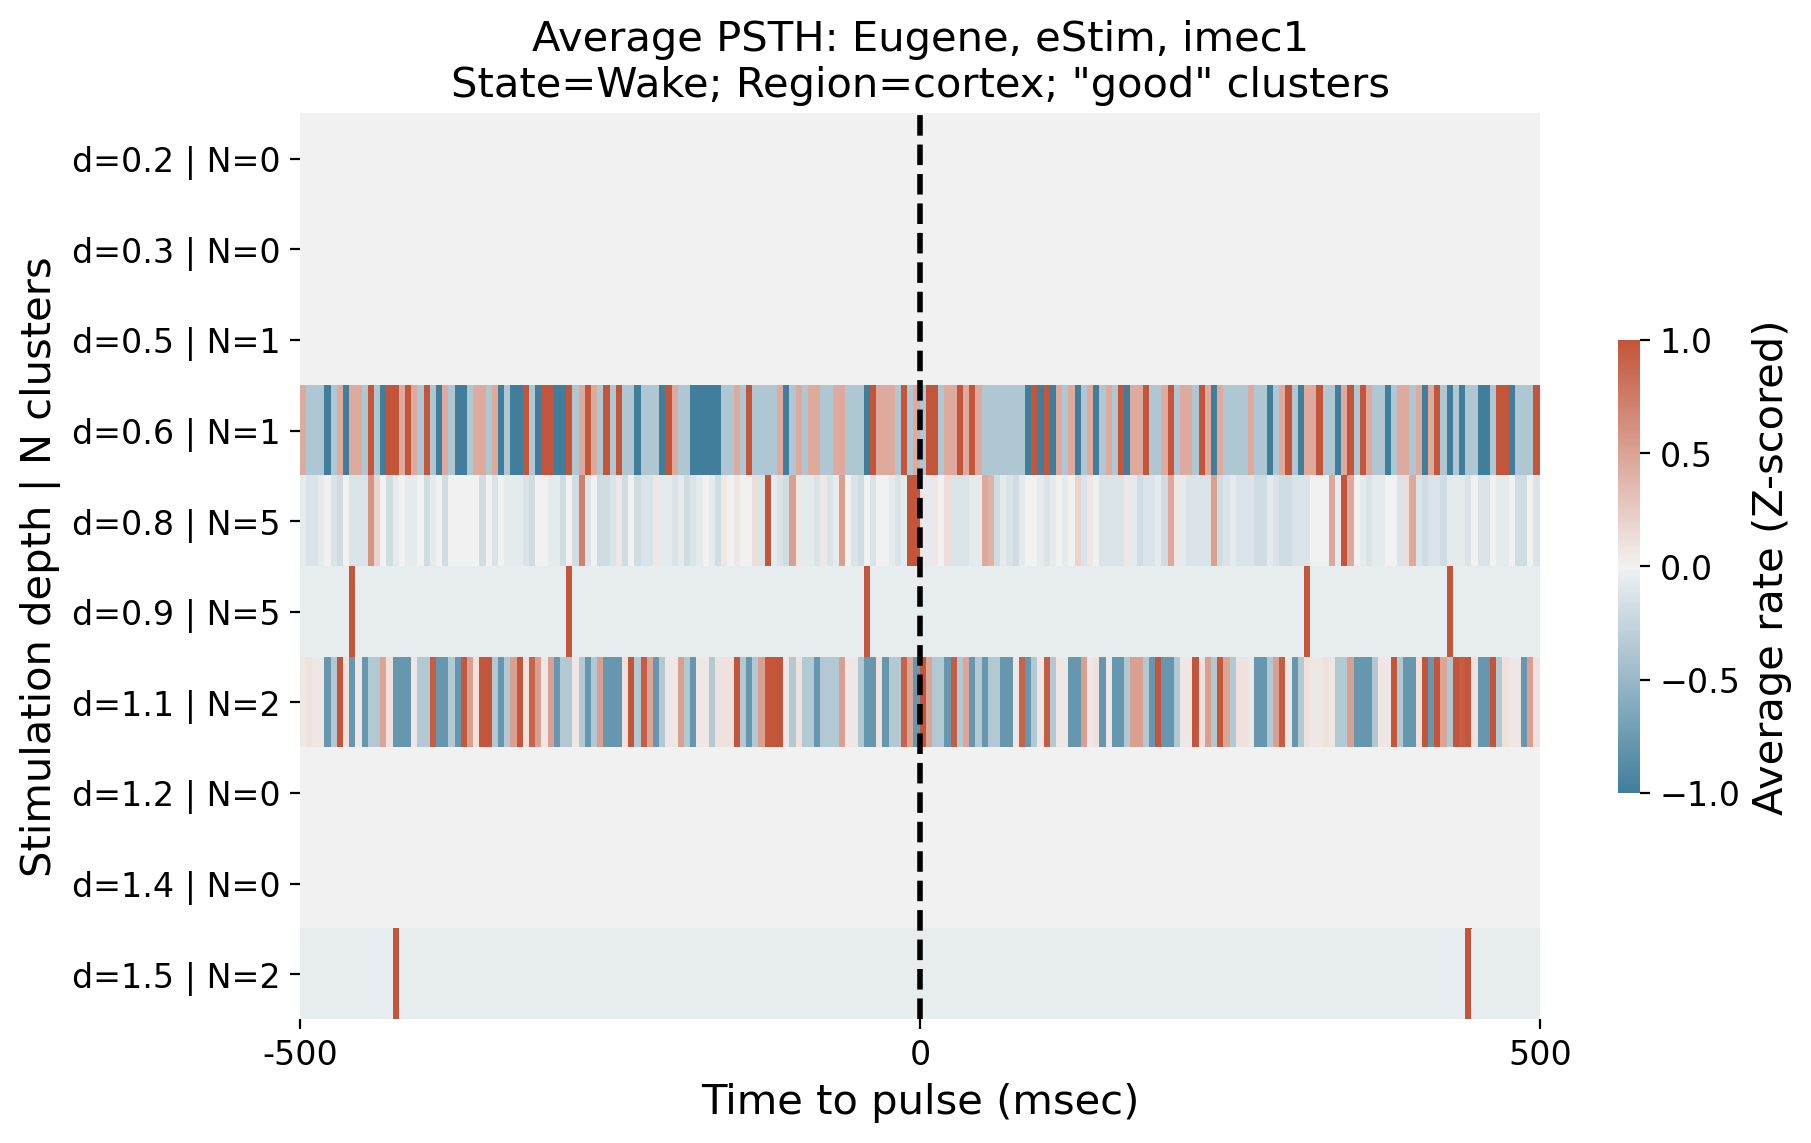

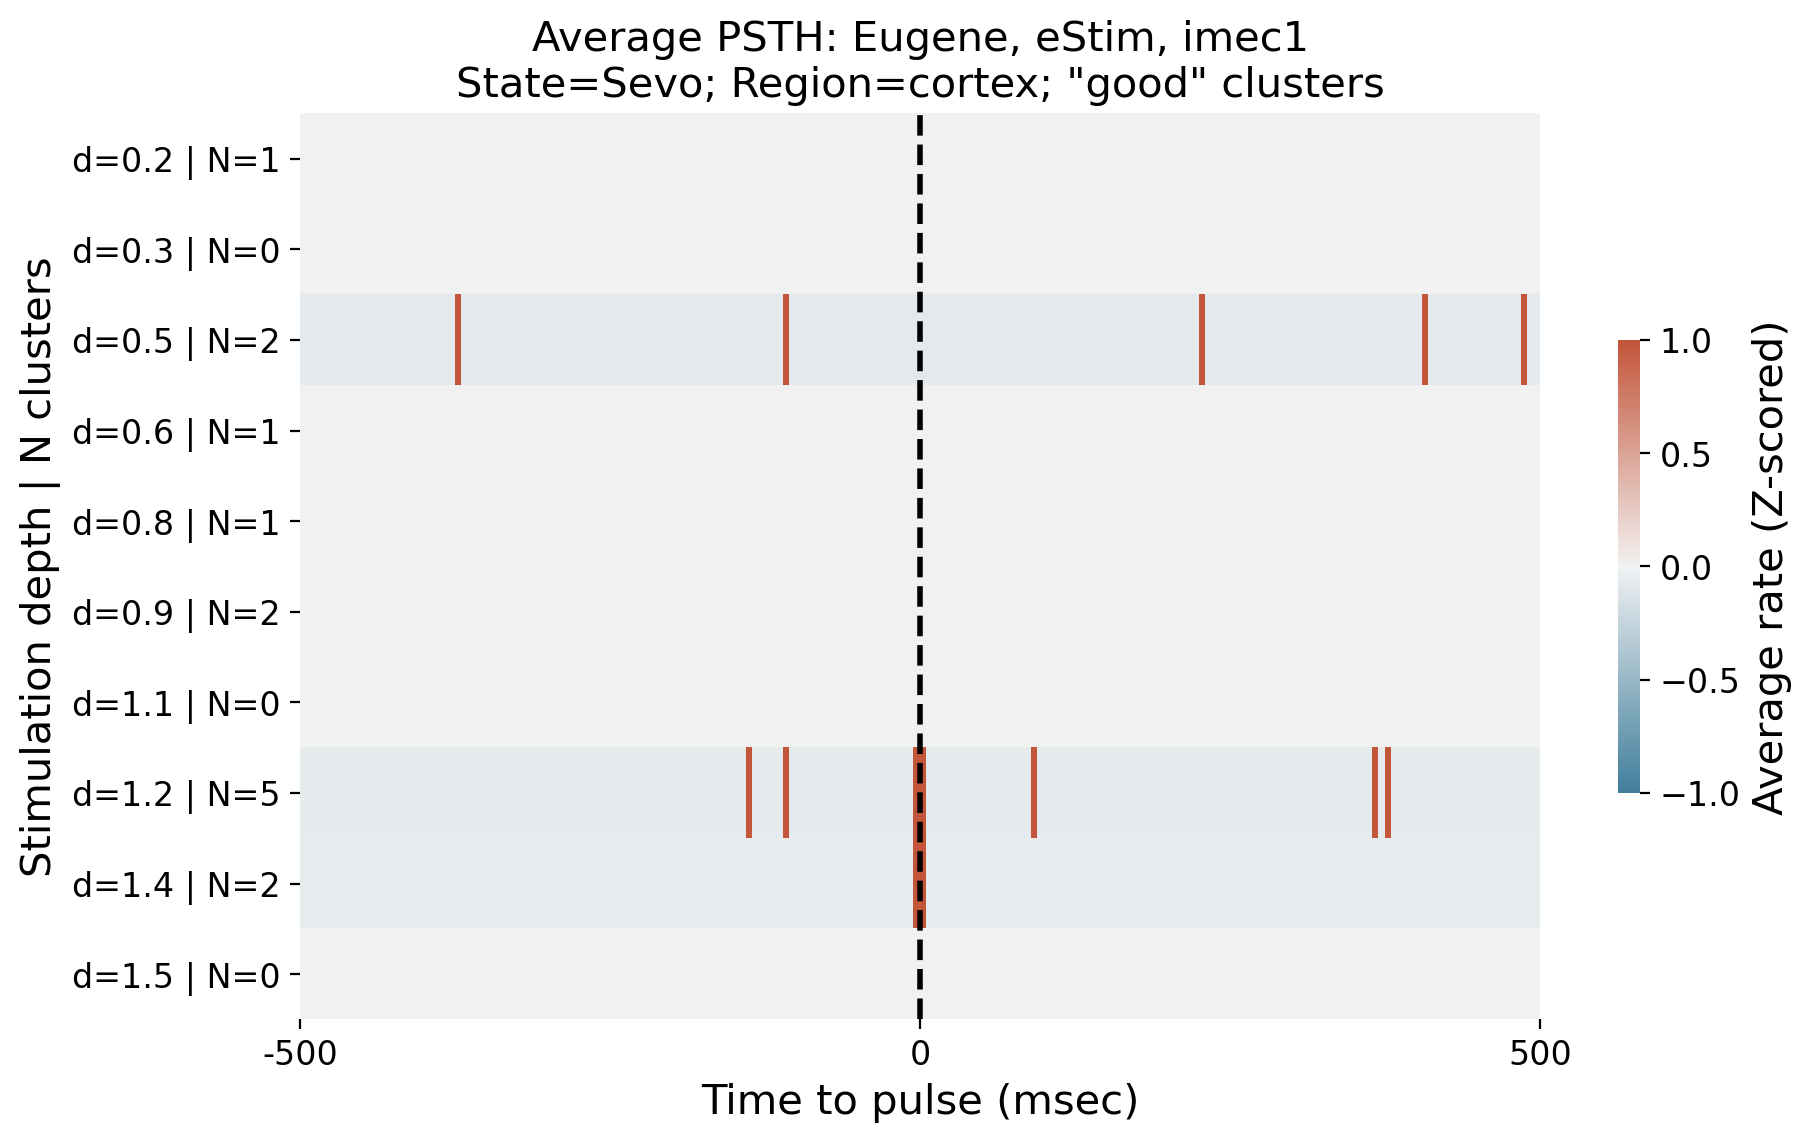

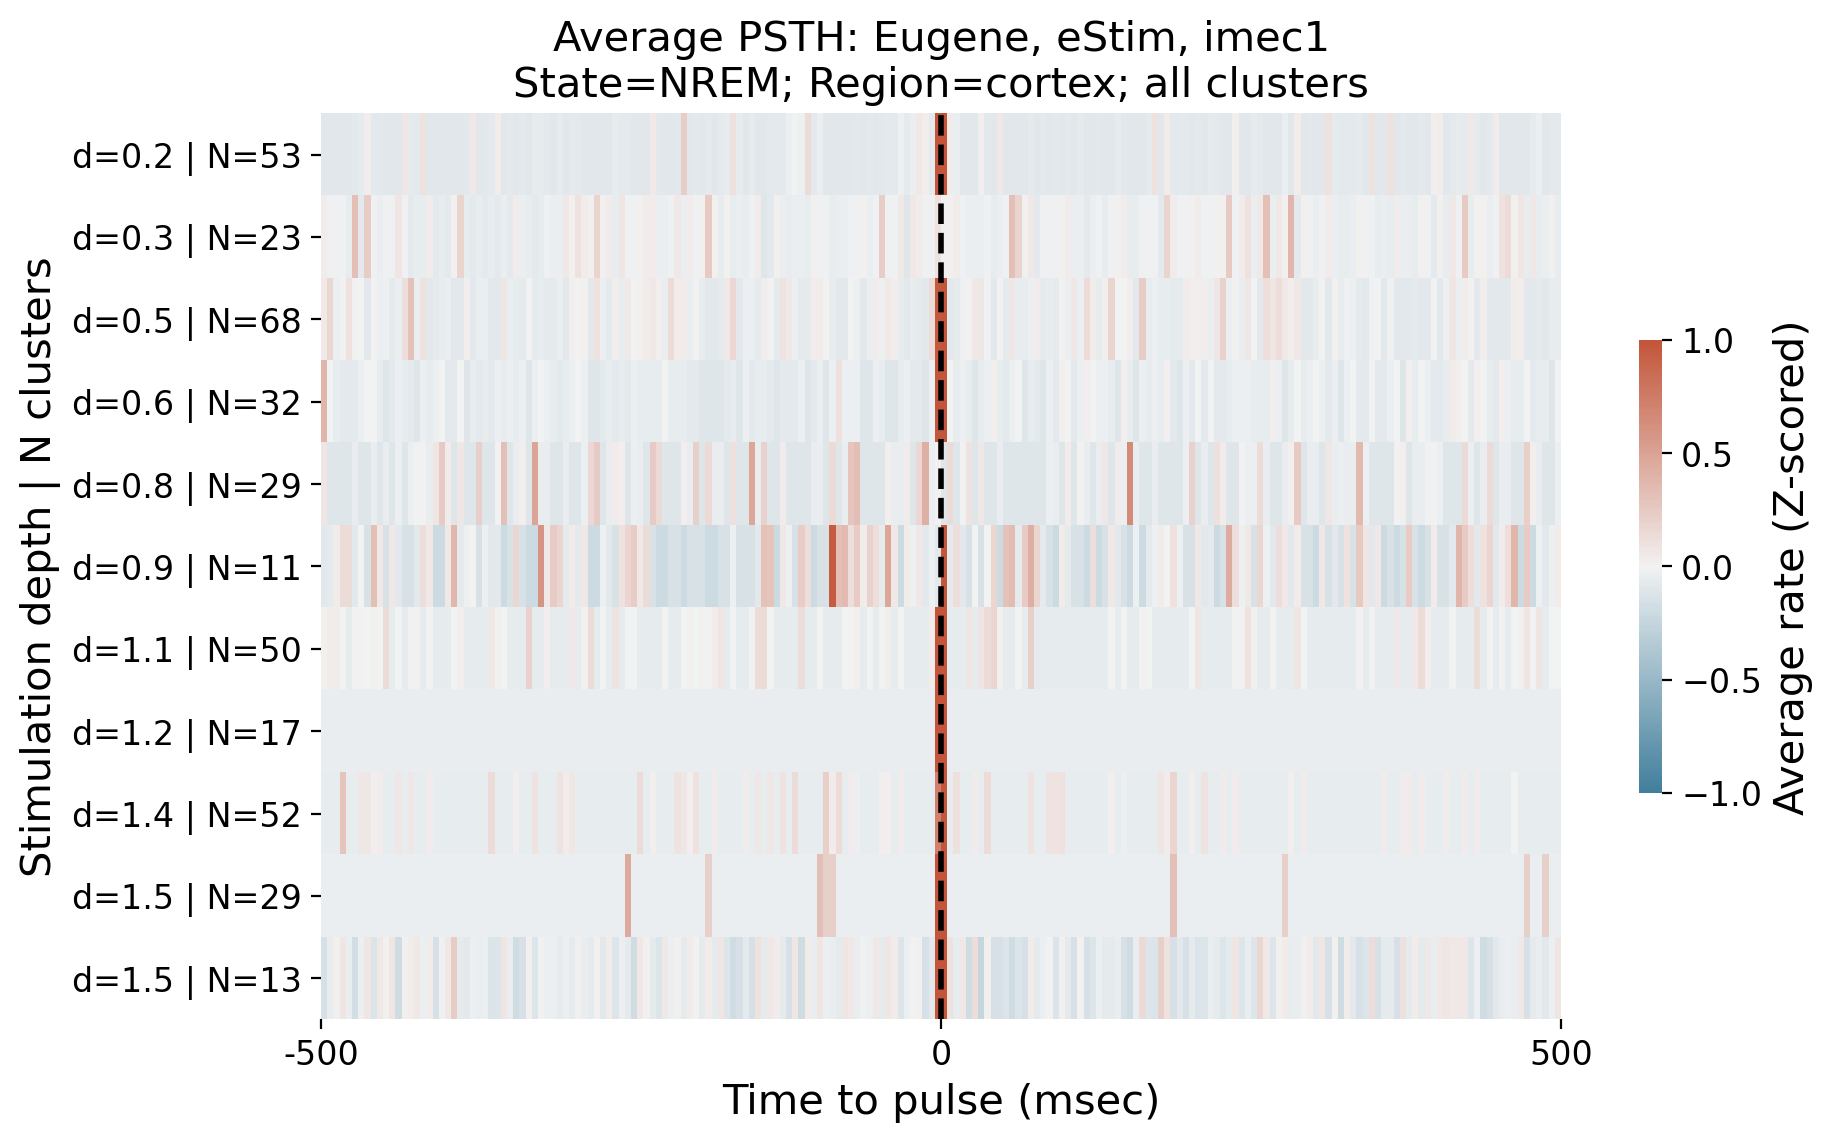

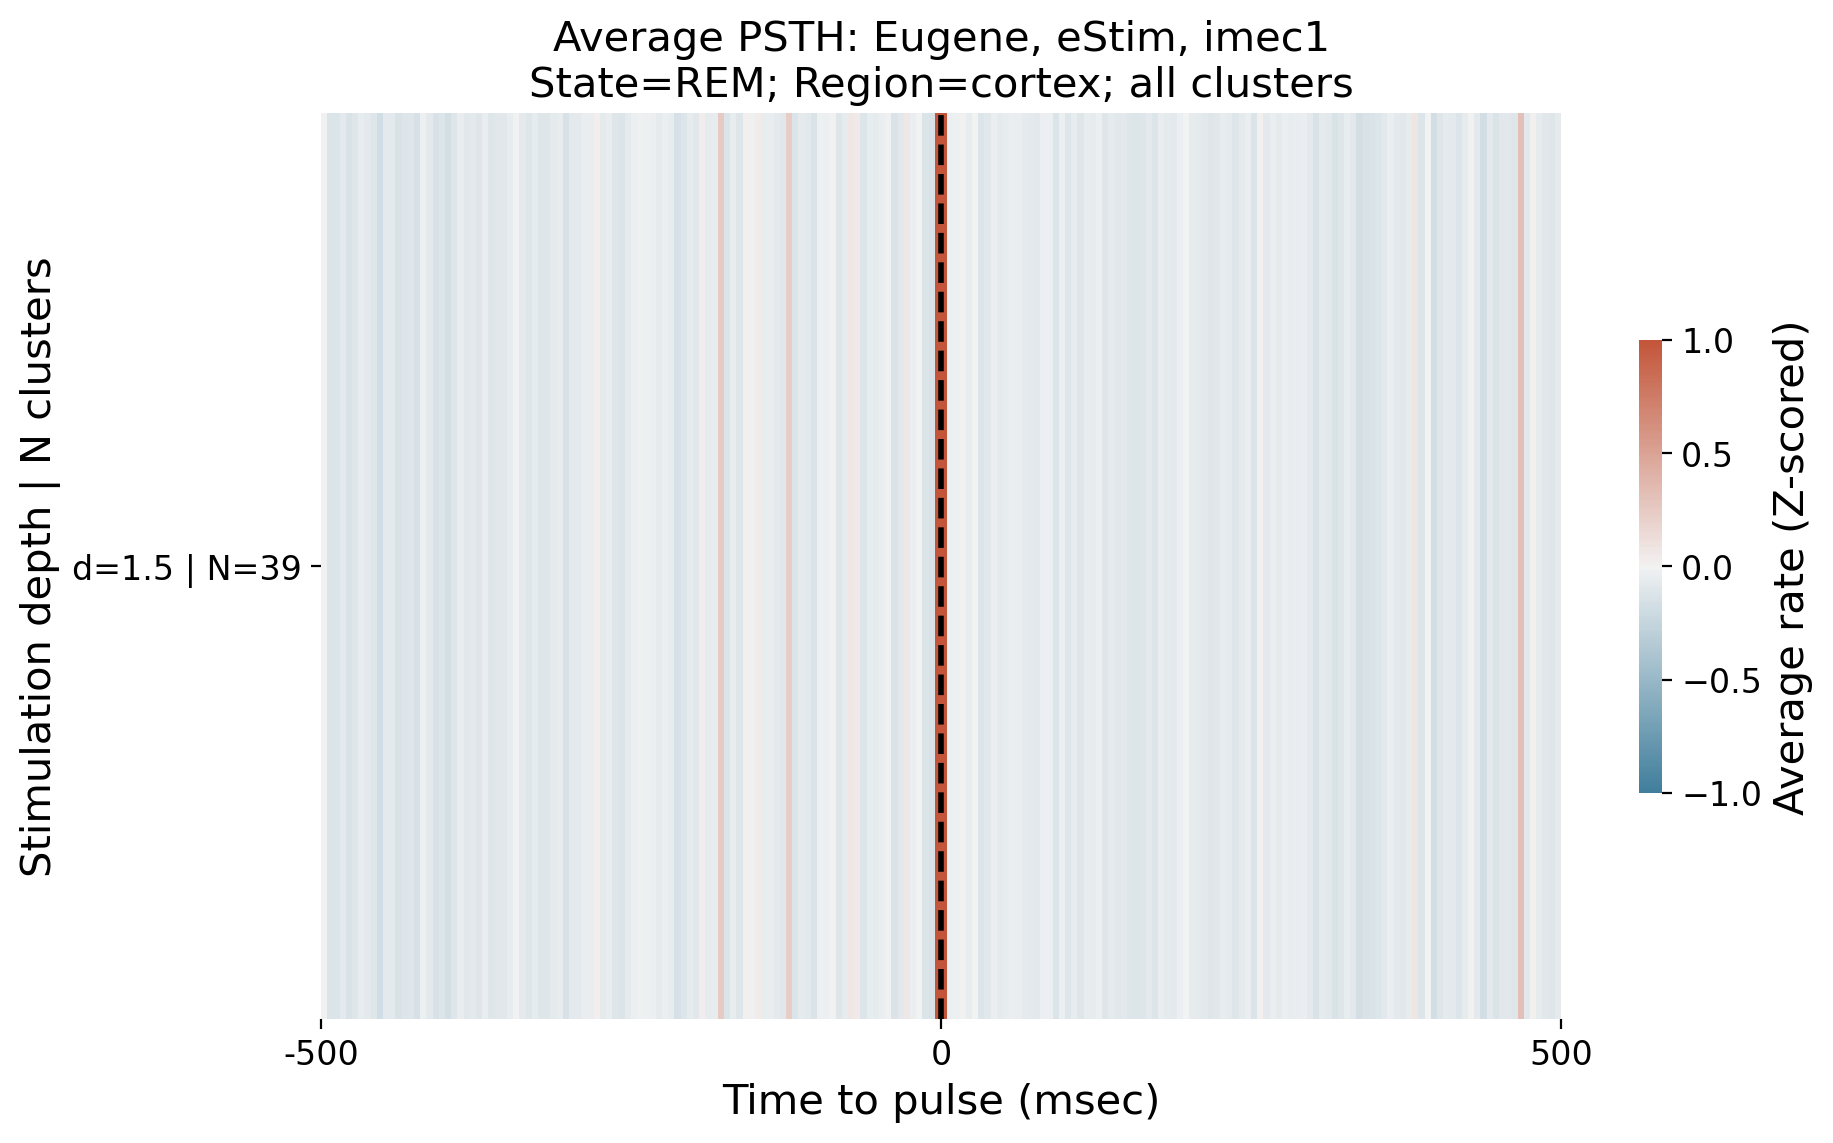

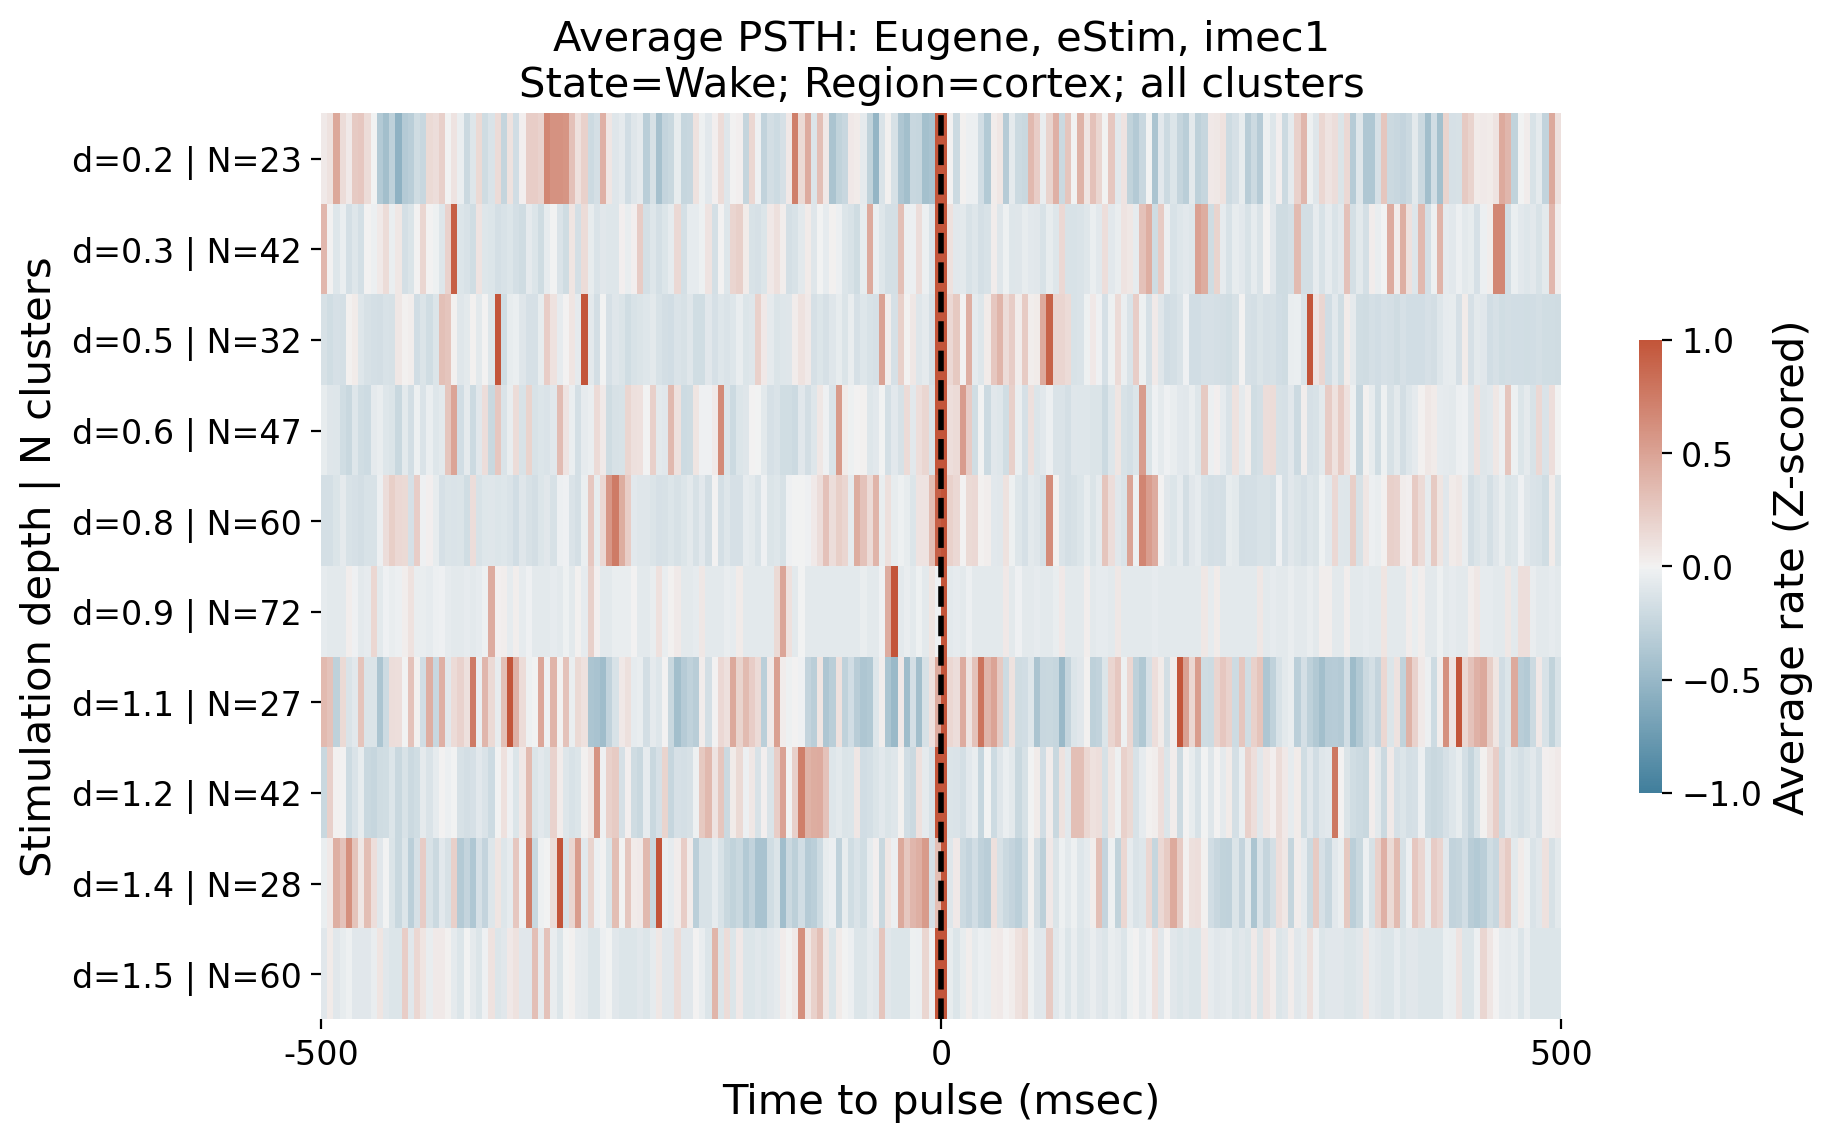

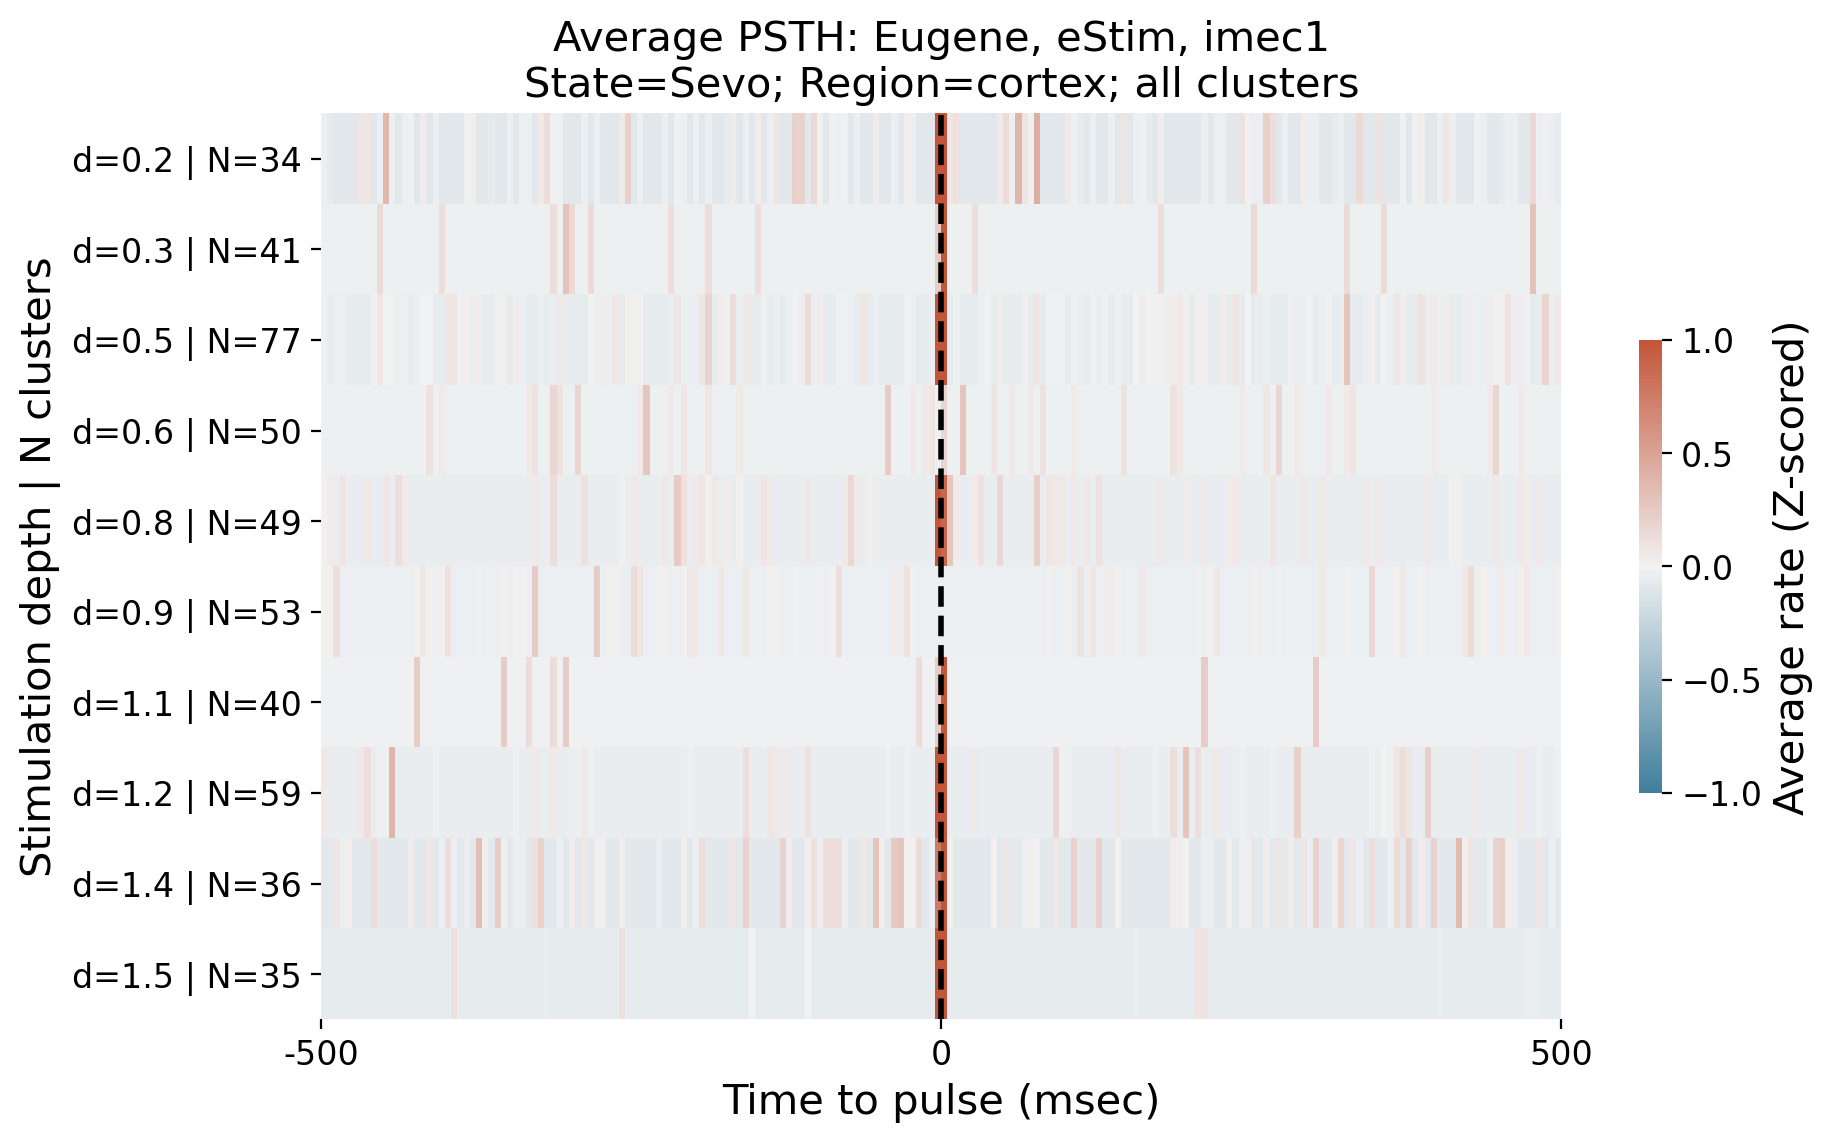

In [159]:
if n_jobs == 1:
    for (
            imec,
            region, 
            good_only,
            clim,
            state,
    ) in itertools.product(
        imecs, regions, good_only_values, clim_values, states
    ):
        make_average_psth_figures(
            subject, condition_group, sorting_condition, imec,
            good_only=good_only, normalize='baseline_zscore',
            region=region, state=state, save=True, show=False,
            clim=clim, output_dir=OUTPUT_DIR, dump_data=True,
        )
else:
    assert False
print('done')